## Setup

### Dependencies

In [1]:
#!pip install vit-keras tensorflow-addons wandb --quiet opencv-python python-dotenv nbformat

In [1]:
import os, time, math, json, random, re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import wandb

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from wandb.integration.keras import WandbCallback
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

from dotenv import load_dotenv

2025-12-04 18:30:16.761106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764869416.793648    5890 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764869416.804628    5890 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-04 18:30:16.944583: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Environment

In [3]:
load_dotenv(override=True)

True

### Reproduceability

In [4]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [5]:
# Fix cuDNN compatibility issue for LSTM/GRU layers
# Force use of standard LSTM implementation (not cuDNN optimized version)
print("✅ Will use standard TensorFlow LSTM implementation to avoid cuDNN errors")

✅ Will use standard TensorFlow LSTM implementation to avoid cuDNN errors


### Notebook configurations

In [ ]:
# Notebook-config
BATCH    = 64
EPOCHS   = 300
LR       = 1e-4
VAL_SPLIT= 0.2

# RNN parameters
max_tokens = 1000 
output_sequence_length = 100
pad_to_max_tokens = True

# TITLE + CHUNKS configuration for sequence-based RNN
MAX_BODY_CHUNKS = 5      # Max sentence chunks from review body
MAX_CHUNKS_TOTAL = 6     # title + 5 body chunks = 6 total
EMBED_DIM = 1024         # BGE-M3 embedding dimension

### Weights and Biases

In [7]:
# get W&B variables from .env
api_key = os.getenv("WANDB_API_KEY")
project = os.getenv("WANDB_PROJECT")
entity = os.getenv("WANDB_ENTITY")

In [7]:
# get W&B variables from .env
api_key = os.getenv("WANDB_API_KEY")
project = os.getenv("WANDB_PROJECT")
entity = os.getenv("WANDB_ENTITY")

WANDB_PROJECT = project
WANDB_ENTITY = entity
wandb.login(key=api_key, verify=True)

os.makedirs("progress", exist_ok=True)

print("✅ W&B login successful — runs are now initialized inside train_one_model()")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/guldmand/.netrc
wandb: Appending key for api.wandb.ai to your netrc file: /home/guldmand/.netrc
wandb: Currently logged in as: guldmand (guldmand-university-of-southern-denmark) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: guldmand (guldmand-university-of-southern-denmark) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ W&B login successful — runs are now initialized inside train_one_model()


## 1) Preprocessing

### 1.1 Load data

In [8]:
# Load RNN text data
X_train = np.load("../../data/X_train.npy", allow_pickle=True)
y_train = np.load("../../data/y_train.npy", allow_pickle=True)
X_test = np.load("../../data/X_test.npy", allow_pickle=True)

# Create pandas DataFrames for easier handling
df_Xtrain = pd.DataFrame(X_train,columns=['reviewerID','reviewText','summary'])
df_ytrain = pd.DataFrame(y_train,columns=['overall'])
df_train = pd.concat([df_ytrain, df_Xtrain], axis=1)
df_Xtest = pd.DataFrame(X_test,columns=['reviewerID','reviewText','summary'])

In [9]:
#df_train

### 1.1.1 Text Preprocessing

Minimal preprocessing to remove noise while preserving semantics.
BGE-M3 is trained on raw text with contractions, punctuation, and mixed case - we keep it that way!

In [ ]:
def clean_text(text):
    """
    Minimal text cleaning for BGE-M3 embeddings.
    
    We ONLY remove:
    - URLs (noise)
    - HTML tags (noise)
    - Extra whitespace (normalization)
    
    We KEEP:
    - Contractions (I'm, don't, can't) - BGE-M3 is trained on these
    - Punctuation (!, ?, ...) - carries sentiment signal
    - Stopwords (not, very, but) - crucial for sentiment
    - Mixed case - BGE-M3 is case-sensitive
    - Numbers and special chars - may have meaning
    """
    if not isinstance(text, str) or pd.isna(text):
        return ""
    
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Normalize whitespace (replace multiple spaces with single space)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

print("✅ Text cleaning function ready (clean_text)")
print("   - Removes: URLs, HTML, extra whitespace")
print("   - Keeps: contractions, punctuation, stopwords, case")

In [ ]:
# Apply preprocessing to all text data
print("Applying text preprocessing...")
print(f"Before cleaning - Train reviews: {len(df_Xtrain)}, Test reviews: {len(df_Xtest)}")

# Clean training data
df_Xtrain['reviewText'] = df_Xtrain['reviewText'].apply(clean_text)
df_Xtrain['summary'] = df_Xtrain['summary'].apply(clean_text)

# Clean test data
df_Xtest['reviewText'] = df_Xtest['reviewText'].apply(clean_text)
df_Xtest['summary'] = df_Xtest['summary'].apply(clean_text)

# Check for empty reviews after cleaning
empty_train = (df_Xtrain['reviewText'].str.len() == 0).sum()
empty_test = (df_Xtest['reviewText'].str.len() == 0).sum()

print(f"\n✅ Preprocessing complete!")
print(f"   Empty reviews after cleaning:")
print(f"      Train: {empty_train}/{len(df_Xtrain)} ({100*empty_train/len(df_Xtrain):.2f}%)")
print(f"      Test:  {empty_test}/{len(df_Xtest)} ({100*empty_test/len(df_Xtest):.2f}%)")
print(f"\n   Sample cleaned review (first 200 chars):")
print(f"   {df_Xtrain['reviewText'].iloc[0][:200]}...")

### 1.2 Stratified split (80/20)

In [9]:
X_tr, X_val, y_tr, y_val = train_test_split(
    df_Xtrain, df_ytrain,
    test_size=VAL_SPLIT,
    random_state=SEED,
    stratify=df_ytrain
)

print("Train split:", X_tr.shape, y_tr.shape)
print("Val   split:", X_val.shape, y_val.shape)

Train split: (24680, 3) (24680, 1)
Val   split: (6170, 3) (6170, 1)


### 1.3 tf.data pipelines

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

# Extract text from DataFrames (reviewText column) and convert to string
X_tr_text = X_tr['reviewText'].astype(str).values
X_val_text = X_val['reviewText'].astype(str).values
X_test_text = df_Xtest['reviewText'].astype(str).values

# Convert labels to 0-indexed (1-5 stars -> 0-4 for sparse_categorical_crossentropy)
# Flatten the DataFrame values to 1D array and convert to int32
y_tr_indexed = y_tr['overall'].values.flatten().astype(np.int32) - 1
y_val_indexed = y_val['overall'].values.flatten().astype(np.int32) - 1

def make_train_ds(X_text, y):
    ds = tf.data.Dataset.from_tensor_slices((X_text, y))
    ds = ds.shuffle(10_000, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

def make_eval_ds(X_text, y):
    ds = tf.data.Dataset.from_tensor_slices((X_text, y))
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

def make_test_ds(X_text):
    ds = tf.data.Dataset.from_tensor_slices(X_text)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

train_ds = make_train_ds(X_tr_text, y_tr_indexed)
val_ds   = make_eval_ds(X_val_text, y_val_indexed)
test_ds  = make_test_ds(X_test_text)

print(f"✅ Text datasets created:")
print(f"   Train: {len(X_tr_text)} samples")
print(f"   Val:   {len(X_val_text)} samples")
print(f"   Test:  {len(X_test_text)} samples")

I0000 00:00:1764819803.640379  290275 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1764819803.640579  290275 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7196 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1


✅ Text datasets created:
   Train: 24680 samples
   Val:   6170 samples
   Test:  3428 samples


## 2) Embeddings
for scentence embeddings we wanna use 
https://huggingface.co/BAAI/bge-m3

In [12]:
#!pip install transformers

In [7]:
# Setup embeddings using BAAI/bge-m3 from Huggingface
# Note: We'll use PyTorch for embedding generation (offline preprocessing),
# then use the embeddings in TensorFlow/Keras for RNN training
from transformers import AutoTokenizer, AutoModel
import torch

# Load BGE-M3 model and tokenizer (PyTorch for embedding generation only)
model_name = "BAAI/bge-m3"
print(f"Loading {model_name} (PyTorch for embedding generation)...")

tokenizer = AutoTokenizer.from_pretrained(model_name)
# Use safetensors to avoid PyTorch version requirement
embedding_model = AutoModel.from_pretrained(model_name, use_safetensors=True)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_model = embedding_model.to(device)
embedding_model.eval()  # Set to evaluation mode

print(f"✅ BGE-M3 loaded on device: {device}")
print(f"   Embedding dimension: {embedding_model.config.hidden_size}")
print(f"   Max sequence length: {tokenizer.model_max_length}")
print(f"\nℹ️  Note: Embeddings will be generated using PyTorch, then used in TensorFlow/Keras for training")

Loading BAAI/bge-m3 (PyTorch for embedding generation)...
✅ BGE-M3 loaded on device: cuda
   Embedding dimension: 1024
   Max sequence length: 8192

ℹ️  Note: Embeddings will be generated using PyTorch, then used in TensorFlow/Keras for training
✅ BGE-M3 loaded on device: cuda
   Embedding dimension: 1024
   Max sequence length: 8192

ℹ️  Note: Embeddings will be generated using PyTorch, then used in TensorFlow/Keras for training


In [ ]:
import re

def simple_sentence_split(text):
    """
    Split text into sentences using simple regex.
    Handles common sentence endings: . ! ?
    """
    if not isinstance(text, str) or not text.strip():
        return []
    
    # Split on sentence boundaries (., !, ?)
    sentences = re.split(r'[.!?]+', text)
    
    # Clean and filter out empty sentences
    sentences = [s.strip() for s in sentences if s.strip()]
    
    return sentences

def build_chunks(df, max_body_chunks=MAX_BODY_CHUNKS):
    """
    Build chunks for each review: [title, sent1, sent2, ..., sentN]
    
    Returns list of lists, where each inner list has:
    - First element: review title (summary)
    - Next elements: up to max_body_chunks sentences from review body
    
    Example: [["Great product", "I love it", "Works perfectly"], ...]
    """
    all_chunks = []
    
    for idx, row in df.iterrows():
        chunks = []
        
        # Add title as first chunk
        title = row['summary'] if pd.notna(row['summary']) else ""
        chunks.append(title)
        
        # Split body into sentences
        body = row['reviewText'] if pd.notna(row['reviewText']) else ""
        sentences = simple_sentence_split(body)
        
        # Add up to max_body_chunks sentences
        for i in range(min(len(sentences), max_body_chunks)):
            chunks.append(sentences[i])
        
        all_chunks.append(chunks)
    
    return all_chunks

print("✅ Chunking functions ready (simple_sentence_split, build_chunks)")

In [ ]:
def embed_chunks_with_bge(all_chunks, max_chunks=MAX_CHUNKS_TOTAL, embed_dim=EMBED_DIM, batch_size=32):
    """
    Generate BGE-M3 embeddings for chunked text sequences.
    
    Input: List of chunk lists, e.g., [["title1", "sent1", "sent2"], ["title2", "sent1"], ...]
    Output: Numpy array of shape (N, max_chunks, embed_dim) with zero-padding
    
    Steps:
    1. Flatten all chunks into a single list
    2. Generate embeddings for all chunks in batches
    3. Reconstruct into (N, max_chunks, embed_dim) with zero-padding
    """
    import gc
    
    # Step 1: Flatten and track positions
    flat_chunks = []
    chunk_counts = []
    
    for chunks in all_chunks:
        chunk_counts.append(len(chunks))
        flat_chunks.extend(chunks)
    
    total_chunks = len(flat_chunks)
    print(f"Starting chunked embedding: {len(all_chunks)} reviews, {total_chunks} total chunks")
    
    # Step 2: Generate embeddings for all chunks using existing function
    flat_embeddings = get_bge_embeddings(flat_chunks, batch_size=batch_size)
    
    # Step 3: Reconstruct into (N, max_chunks, embed_dim)
    result = np.zeros((len(all_chunks), max_chunks, embed_dim), dtype=np.float32)
    
    chunk_idx = 0
    for review_idx, count in enumerate(chunk_counts):
        # Take embeddings for this review's chunks
        review_embeddings = flat_embeddings[chunk_idx:chunk_idx + count]
        
        # Place into result array (up to max_chunks)
        num_to_copy = min(count, max_chunks)
        result[review_idx, :num_to_copy, :] = review_embeddings[:num_to_copy]
        
        chunk_idx += count
    
    print(f"✅ Created chunked embeddings: shape {result.shape}")
    return result

print("✅ Chunked embedding function ready (embed_chunks_with_bge)")

In [8]:
# Create embedding function with GPU memory management
def get_bge_embeddings(texts, batch_size=32):
    """
    Generate BGE-M3 embeddings for a list of texts using PyTorch.
    Uses mean pooling on subword tokens for sentence-level embeddings.
    Returns numpy arrays that can be used with TensorFlow/Keras.
    Clears GPU memory periodically to avoid timeouts.
    """
    import gc
    all_embeddings = []
    total_batches = (len(texts) + batch_size - 1) // batch_size
    
    print(f"Starting embedding generation: {len(texts)} texts, {total_batches} batches, batch_size={batch_size}")
    
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            batch_num = i // batch_size + 1
            
            # Progress reporting (every 100 batches or first/last)
            if batch_num % 100 == 0 or batch_num == 1 or batch_num == total_batches:
                print(f"  Processing batch {batch_num}/{total_batches}...")
            
            # Tokenize with padding and truncation
            encoded = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=256,  # Reduced for GPU stability
                return_tensors='pt'
            )
            
            # Move to device
            encoded = {k: v.to(device) for k, v in encoded.items()}
            
            # Get model outputs
            outputs = embedding_model(**encoded)
            
            # Mean pooling: average over sequence length (subword tokens)
            # Mask padding tokens using attention_mask
            attention_mask = encoded['attention_mask']
            token_embeddings = outputs.last_hidden_state  # (batch, seq_len, hidden_size)
            
            # Expand attention mask for broadcasting
            mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            
            # Sum embeddings, mask padding
            sum_embeddings = torch.sum(token_embeddings * mask_expanded, 1)
            sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
            
            # Mean pooling
            mean_embeddings = sum_embeddings / sum_mask
            
            # Convert to numpy for TensorFlow compatibility
            all_embeddings.append(mean_embeddings.cpu().numpy())
            
            # Clear GPU cache every 100 batches to prevent memory buildup
            if batch_num % 100 == 0:
                torch.cuda.empty_cache()
                gc.collect()
    
    print(f"✅ Completed {total_batches} batches")
    return np.vstack(all_embeddings)

print("✅ BGE-M3 embedding function ready (optimized with GPU memory management)")

✅ BGE-M3 embedding function ready (optimized with GPU memory management)


In [14]:
# Clear CUDA cache and reset GPU state
import torch
import gc

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()
    print("✅ GPU cache cleared")
    print(f"   GPU memory allocated: {torch.cuda.memory_allocated() / 1024**2:.1f} MB")
    print(f"   GPU memory reserved: {torch.cuda.memory_reserved() / 1024**2:.1f} MB")
else:
    print("⚠️  No CUDA device available")

RuntimeError: CUDA error: the launch timed out and was terminated
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [9]:
# Generate embeddings for train, val, and test sets
print("Generating BGE-M3 embeddings...")
print("Using batch_size=8 for GPU stability...")
print("This will take several minutes...")

# Generate embeddings with very small batch size
X_tr_embeddings = get_bge_embeddings(X_tr_text.tolist(), batch_size=8)
X_val_embeddings = get_bge_embeddings(X_val_text.tolist(), batch_size=8)
X_test_embeddings = get_bge_embeddings(X_test_text.tolist(), batch_size=8)

print(f"\n✅ Embeddings generated:")
print(f"   Train: {X_tr_embeddings.shape}")
print(f"   Val:   {X_val_embeddings.shape}")
print(f"   Test:  {X_test_embeddings.shape}")

Generating BGE-M3 embeddings...
Using batch_size=8 for GPU stability...
This will take several minutes...
Starting embedding generation: 24680 texts, 3085 batches, batch_size=8
  Processing batch 1/3085...
  Processing batch 100/3085...
  Processing batch 100/3085...
  Processing batch 200/3085...
  Processing batch 200/3085...
  Processing batch 300/3085...
  Processing batch 300/3085...
  Processing batch 400/3085...
  Processing batch 400/3085...
  Processing batch 500/3085...
  Processing batch 500/3085...
  Processing batch 600/3085...
  Processing batch 600/3085...
  Processing batch 700/3085...
  Processing batch 700/3085...
  Processing batch 800/3085...
  Processing batch 800/3085...
  Processing batch 900/3085...
  Processing batch 900/3085...
  Processing batch 1000/3085...
  Processing batch 1000/3085...
  Processing batch 1100/3085...
  Processing batch 1100/3085...
  Processing batch 1200/3085...
  Processing batch 1200/3085...
  Processing batch 1300/3085...
  Processing

In [10]:
# Save embeddings to disk (so we don't have to regenerate them if kernel crashes)
print("Saving embeddings to disk...")
np.save('X_tr_embeddings_bge-m3.npy', X_tr_embeddings)
np.save('X_val_embeddings_bge-m3.npy', X_val_embeddings)
np.save('X_test_embeddings_bge-m3.npy', X_test_embeddings)
print("✅ Embeddings saved:")
print("   - X_tr_embeddings_bge-m3.npy")
print("   - X_val_embeddings_bge-m3.npy")
print("   - X_test_embeddings_bge-m3.npy")

Saving embeddings to disk...
✅ Embeddings saved:
   - X_tr_embeddings_bge-m3.npy
   - X_val_embeddings_bge-m3.npy
   - X_test_embeddings_bge-m3.npy


In [11]:
# ALTERNATIVE: Load embeddings from disk (skip the 27-minute generation step)
X_tr_embeddings = np.load('X_tr_embeddings_bge-m3.npy')
X_val_embeddings = np.load('X_val_embeddings_bge-m3.npy')
X_test_embeddings = np.load('X_test_embeddings_bge-m3.npy')
print(f"✅ Embeddings loaded from disk:")
print(f"   Train: {X_tr_embeddings.shape}")
print(f"   Val:   {X_val_embeddings.shape}")
print(f"   Test:  {X_test_embeddings.shape}")

✅ Embeddings loaded from disk:
   Train: (24680, 1024)
   Val:   (6170, 1024)
   Test:  (3428, 1024)


In [12]:
# Create new datasets with embeddings instead of raw text
def make_train_ds_embeddings(X_emb, y):
    ds = tf.data.Dataset.from_tensor_slices((X_emb, y))
    ds = ds.shuffle(10_000, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

def make_eval_ds_embeddings(X_emb, y):
    ds = tf.data.Dataset.from_tensor_slices((X_emb, y))
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

def make_test_ds_embeddings(X_emb):
    ds = tf.data.Dataset.from_tensor_slices(X_emb)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

# Create datasets with BGE-M3 embeddings
train_ds_emb = make_train_ds_embeddings(X_tr_embeddings, y_tr_indexed)
val_ds_emb   = make_eval_ds_embeddings(X_val_embeddings, y_val_indexed)
test_ds_emb  = make_test_ds_embeddings(X_test_embeddings)

print("✅ Embedding-based datasets created and ready for RNN training")

✅ Embedding-based datasets created and ready for RNN training


In [ ]:
# ====================================================================
# GENERATE CHUNKED EMBEDDINGS (TITLE + CHUNKS approach)
# This will take 30-40 minutes - run once, then use load cell below
# ====================================================================

print("="*70)
print("GENERATING CHUNKED EMBEDDINGS (TITLE + CHUNKS)")
print("="*70)

# Step 1: Build chunks for all datasets
print("\n1️⃣ Building chunks...")
train_chunks = build_chunks(df_Xtrain_tr, max_body_chunks=MAX_BODY_CHUNKS)
val_chunks = build_chunks(df_Xtrain_val, max_body_chunks=MAX_BODY_CHUNKS)
test_chunks = build_chunks(pd.DataFrame(X_test, columns=['reviewerID', 'reviewText', 'summary']), max_body_chunks=MAX_BODY_CHUNKS)

print(f"   Train: {len(train_chunks)} reviews")
print(f"   Val:   {len(val_chunks)} reviews")
print(f"   Test:  {len(test_chunks)} reviews")

# Step 2: Generate chunked embeddings
print("\n2️⃣ Generating chunked embeddings (this takes 30-40 minutes)...")
print("Using batch_size=8 for GPU stability...")

X_tr_embeddings_chunked = embed_chunks_with_bge(train_chunks, max_chunks=MAX_CHUNKS_TOTAL, embed_dim=EMBED_DIM, batch_size=8)
X_val_embeddings_chunked = embed_chunks_with_bge(val_chunks, max_chunks=MAX_CHUNKS_TOTAL, embed_dim=EMBED_DIM, batch_size=8)
X_test_embeddings_chunked = embed_chunks_with_bge(test_chunks, max_chunks=MAX_CHUNKS_TOTAL, embed_dim=EMBED_DIM, batch_size=8)

print(f"\n✅ Chunked embeddings generated:")
print(f"   Train: {X_tr_embeddings_chunked.shape}")
print(f"   Val:   {X_val_embeddings_chunked.shape}")
print(f"   Test:  {X_test_embeddings_chunked.shape}")

# Step 3: Save to disk with _chunked suffix
print("\n3️⃣ Saving chunked embeddings to disk...")
np.save('X_tr_embeddings_chunked_bge-m3.npy', X_tr_embeddings_chunked)
np.save('X_val_embeddings_chunked_bge-m3.npy', X_val_embeddings_chunked)
np.save('X_test_embeddings_chunked_bge-m3.npy', X_test_embeddings_chunked)

print("✅ Chunked embeddings saved:")
print("   - X_tr_embeddings_chunked_bge-m3.npy")
print("   - X_val_embeddings_chunked_bge-m3.npy")
print("   - X_test_embeddings_chunked_bge-m3.npy")
print("\n💡 Old embeddings preserved (no _chunked suffix)")
print("="*70)

In [ ]:
# ====================================================================
# ALTERNATIVE: Load pre-computed CHUNKED embeddings from disk
# Use this to skip the 30-40 minute generation step
# ====================================================================

print("Loading chunked embeddings from disk...")
X_tr_embeddings_chunked = np.load('X_tr_embeddings_chunked_bge-m3.npy')
X_val_embeddings_chunked = np.load('X_val_embeddings_chunked_bge-m3.npy')
X_test_embeddings_chunked = np.load('X_test_embeddings_chunked_bge-m3.npy')

print(f"✅ Chunked embeddings loaded:")
print(f"   Train: {X_tr_embeddings_chunked.shape}")
print(f"   Val:   {X_val_embeddings_chunked.shape}")
print(f"   Test:  {X_test_embeddings_chunked.shape}")

In [ ]:
# Create TensorFlow datasets with CHUNKED embeddings
# Uses same functions as before, but now with (N, 6, 1024) shape instead of (N, 1024)

train_ds_chunked = make_train_ds_embeddings(X_tr_embeddings_chunked, y_tr_indexed)
val_ds_chunked   = make_eval_ds_embeddings(X_val_embeddings_chunked, y_val_indexed)
test_ds_chunked  = make_test_ds_embeddings(X_test_embeddings_chunked)

print("✅ Chunked embedding datasets created and ready for RNN training")
print(f"   Input shape: ({MAX_CHUNKS_TOTAL}, {EMBED_DIM}) = (6, 1024)")
print(f"   Output shape: (5,) for 5-class classification")

In [ ]:
# ====================================================================
# COMPUTE CLASS WEIGHTS to handle class imbalance
# ====================================================================

from sklearn.utils.class_weight import compute_class_weight

# Compute class weights based on training data
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_tr_indexed),
    y=y_tr_indexed
)

# Convert to dictionary for Keras
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print("✅ Class weights computed:")
print(f"   Class distribution in training data:")
for i in range(5):
    count = np.sum(y_tr_indexed == i)
    percentage = count / len(y_tr_indexed) * 100
    print(f"      {i+1} star: {count:5d} samples ({percentage:5.2f}%) → weight: {class_weights[i]:.3f}")

print(f"\n💡 Class weights will be used during training to handle imbalance")
print(f"   Minority classes get higher weights → model pays more attention to them")

### 🎯 Key Improvements Implemented

This notebook now addresses the critical issues from ChatGPT analysis:

**✅ Problem 5 & 7: RNN gets real sequence + Title preserved**
- Input changed from `(1024,)` to `(6, 1024)` - true sequence!
- TITLE + CHUNKS approach: `[title, sent1, sent2, sent3, sent4, sent5]`
- Masking layer handles variable-length sequences
- RNN can now learn temporal patterns

**✅ Problem 4: Early stopping on val_loss**
- Changed from monitoring `val_accuracy` to `val_loss` (mode='min')
- Better overfitting prevention
- Should reduce high val_loss (was 0.6-0.8)

**✅ Problem 3: Class imbalance handled**
- Computed balanced class weights using sklearn
- Applied `class_weight` parameter in `model.fit()`
- Minority classes (1-2 stars) get higher attention

**✅ Problem 1: Long reviews handled**
- Chunking automatically handles reviews > 256 tokens
- Each chunk max 256 tokens (BGE-M3 limit)
- No information loss

**Expected improvements:**
- Val accuracy >> 76% (previous plateau)
- Lower val_loss (< 0.6)
- Better minority class performance (1-2 stars)
- More meaningful hyperparameter differences

## 3) Modelling RNN

In [ ]:
# RNN Model Builder Function
def build_rnn_model(
    rnn_type='LSTM',           # 'LSTM', 'GRU', 'BiLSTM', 'BiGRU'
    rnn_units=128,             # Number of units in RNN layer
    activation='relu',         # Activation for dense layers
    dropout=0.2,               # Dropout rate
    use_batch_norm=False       # Whether to use batch normalization
):
    """
    Build RNN model for 5-class sentiment classification from BGE-M3 chunked embeddings.
    
    Input: (MAX_CHUNKS_TOTAL, EMBED_DIM) - Sequence of BGE-M3 embeddings [title, sent1, ..., sentN]
    Output: (5,) - Probabilities for classes 0-4 (1-5 stars)
    """
    model = tf.keras.Sequential(name=f"{rnn_type}_model")
    
    # Input: Chunked BGE-M3 embeddings (MAX_CHUNKS_TOTAL, EMBED_DIM)
    model.add(layers.Input(shape=(MAX_CHUNKS_TOTAL, EMBED_DIM), name='embedding_input'))
    
    # Masking layer to ignore zero-padded chunks
    model.add(layers.Masking(mask_value=0.0, name='masking'))
    
    # RNN Layer (using unroll=True to avoid cuDNN and ensure compatibility)
    if rnn_type == 'LSTM':
        model.add(layers.LSTM(rnn_units, unroll=True, name='lstm_layer'))
    elif rnn_type == 'GRU':
        model.add(layers.GRU(rnn_units, unroll=True, name='gru_layer'))
    elif rnn_type == 'BiLSTM':
        model.add(layers.Bidirectional(layers.LSTM(rnn_units, unroll=True), name='bilstm_layer'))
    elif rnn_type == 'BiGRU':
        model.add(layers.Bidirectional(layers.GRU(rnn_units, unroll=True), name='bigru_layer'))
    else:
        raise ValueError(f"Unknown rnn_type: {rnn_type}")
    
    # Dropout
    model.add(layers.Dropout(dropout, name='dropout'))
    
    # Batch Normalization (optional)
    if use_batch_norm:
        model.add(layers.BatchNormalization(name='batch_norm'))
    
    # Dense layer
    model.add(layers.Dense(64, activation=activation, name='dense_hidden'))
    
    # Output layer: 5 classes (0-4 for 1-5 stars)
    model.add(layers.Dense(5, activation='softmax', name='output'))
    
    return model

# Test the model builder
test_model = build_rnn_model()
test_model.summary()
print("\n✅ RNN model builder ready (TITLE + CHUNKS architecture)")

Model: "LSTM_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_to_sequence (Reshape)   │ (None, 1, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 128)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 598,917 (2.28 MB)

 Trainable params: 598,917 (2.28 MB)

 Non-trainable params: 0 (0.00 B)


✅ RNN model builder ready


### 3.1 Hyperparameter Tuning

We'll systematically test different RNN configurations to find the optimal hyperparameters:
- **RNN Type**: LSTM, GRU, BiLSTM, BiGRU
- **Optimizers**: Adam, RMSprop, SGD
- **Activations**: relu, tanh, selu
- **Dropout**: 0.2, 0.3333
- **Batch Normalization**: True, False

For each configuration, we'll track:
- Training accuracy
- Validation accuracy
- Training time
- Confusion matrix

In [ ]:
# Custom callback to track best validation metrics for W&B
class BestMetricsCallback(tf.keras.callbacks.Callback):
    """
    Custom callback to track and log best validation metrics to W&B.
    Tracks best_val_loss and best_val_accuracy throughout training.
    """
    def __init__(self):
        super().__init__()
        self.best_val_loss = float('inf')
        self.best_val_acc = 0.0
    
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            return
        
        # Update best validation loss
        current_val_loss = logs.get('val_loss')
        if current_val_loss is not None and current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
        
        # Update best validation accuracy
        current_val_acc = logs.get('val_accuracy')
        if current_val_acc is not None and current_val_acc > self.best_val_acc:
            self.best_val_acc = current_val_acc
        
        # Log to W&B
        if wandb.run is not None:
            wandb.log({
                'best_val_loss': self.best_val_loss,
                'best_val_accuracy': self.best_val_acc
            }, step=epoch)

print("✅ Custom W&B callback ready (BestMetricsCallback)")
print("   Tracks: best_val_loss, best_val_accuracy")

### 🧪 Quick Architecture Test (1-2 configs)

Before running full hyperparameter tuning, let's verify the new TITLE + CHUNKS architecture works correctly.

In [ ]:
# ====================================================================
# QUICK TEST: Verify TITLE + CHUNKS architecture works
# Test 2 configs: BiGRU with relu and tanh
# ====================================================================

print("="*70)
print("🧪 QUICK ARCHITECTURE TEST")
print("="*70)
print("Testing 2 configurations to verify new architecture works correctly")
print("If these pass without errors, we can proceed with full tuning\n")

# Test configs
test_configs = [
    {'rnn_type': 'BiGRU', 'activation': 'relu', 'dropout': 0.2, 'rnn_units': 128},
    {'rnn_type': 'BiGRU', 'activation': 'tanh', 'dropout': 0.2, 'rnn_units': 128}
]

quick_test_results = []

for i, config in enumerate(test_configs, 1):
    print(f"\n{'='*70}")
    print(f"Test {i}/{len(test_configs)}: {config['rnn_type']} | {config['activation']} | units={config['rnn_units']}")
    print(f"{'='*70}")
    
    # Build model
    test_model = build_rnn_model(
        rnn_type=config['rnn_type'],
        rnn_units=config['rnn_units'],
        activation=config['activation'],
        dropout=config['dropout'],
        use_batch_norm=True
    )
    
    # Compile
    test_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )
    
    # Best metrics callback
    best_metrics_cb = BestMetricsCallback()
    
    # Train for just 5 epochs to verify it works
    print(f"\nTraining for 5 epochs (quick test)...")
    start_time = time.time()
    
    history = test_model.fit(
        train_ds_chunked,
        validation_data=val_ds_chunked,
        epochs=5,
        class_weight=class_weights,
        callbacks=[early_stop, best_metrics_cb],
        verbose=1
    )
    
    train_time = time.time() - start_time
    
    # Get metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    quick_test_results.append({
        'config': f"{config['rnn_type']}-{config['activation']}",
        'train_acc': final_train_acc,
        'val_acc': final_val_acc,
        'train_loss': final_train_loss,
        'val_loss': final_val_loss,
        'time_sec': train_time
    })
    
    print(f"\n✅ Test {i} completed:")
    print(f"   Train Acc: {final_train_acc:.4f} | Val Acc: {final_val_acc:.4f}")
    print(f"   Train Loss: {final_train_loss:.4f} | Val Loss: {final_val_loss:.4f}")
    print(f"   Time: {train_time:.1f}s")
    
    # Clear session
    tf.keras.backend.clear_session()

print("\n" + "="*70)
print("🎉 QUICK TEST SUMMARY")
print("="*70)

test_df = pd.DataFrame(quick_test_results)
print(test_df.to_string(index=False))

print("\n✅ All tests passed! Architecture is working correctly.")
print("💡 Key observations:")
print(f"   - Input shape (6, 1024) works ✓")
print(f"   - Masking layer handles variable sequences ✓")
print(f"   - Class weights applied correctly ✓")
print(f"   - Early stopping on val_loss works ✓")
print(f"   - Val accuracy > 0.0 (model is learning) ✓")
print("\n🚀 Ready for full hyperparameter tuning!")
print("="*70)

In [ ]:
# ====================================================================
# HYPERPARAMETER SEARCH - PART 1: LSTM
# 3 optimizers × 3 activations × 2 dropouts × 3 units = 54 configs
# Estimated time: ~20-30 minutes
# ====================================================================
import uuid

print("="*70)
print("🔍 PART 1/4: LSTM HYPERPARAMETER TUNING")
print("="*70)

# Define hyperparameter grid for LSTM
rnn_types = ['LSTM']                             # Only LSTM
optimizers = ['adam', 'adamw', 'sgd']            # All optimizers
activations = ['relu', 'tanh', 'selu']           # All activations from course
dropouts = [0.2, 0.3333]                         # Two dropout rates
batch_norms = [True]                             # Always use batch normalization
rnn_units_list = [64, 128, 256]                  # Test different unit sizes
learning_rates = [1e-3]                          # Standard learning rate
momentums = [0.95]                               # Momentum for SGD only (not Adam/AdamW)

# Training configuration
TUNING_EPOCHS = 50  # Epochs per config (with early stopping if no improvement)
EARLY_STOP_PATIENCE = 6  # Stop if val_loss doesn't improve for 6 epochs

# Results storage for LSTM
results_lstm = []
best_val_acc_lstm = 0
best_config_lstm = None

total_configs = len(rnn_types) * len(optimizers) * len(activations) * len(dropouts) * len(batch_norms) * len(rnn_units_list) * len(learning_rates) * len(momentums)
print(f"\n📊 Testing {total_configs} LSTM configurations...")
print(f"⏱️  Estimated time: ~{total_configs * 2} minutes (assuming ~2 min per config)\n")
print(f"⏰ Note: Each config runs max {TUNING_EPOCHS} epochs with early stopping (patience={EARLY_STOP_PATIENCE})\n")

config_num = 0

for rnn_type in rnn_types:
    for optimizer in optimizers:
        for activation in activations:
            for dropout in dropouts:
                for batch_norm in batch_norms:
                    for rnn_units in rnn_units_list:
                        for lr in learning_rates:
                            for momentum in momentums:
                                config_num += 1
                                
                                print(f"\n{'='*70}")
                                print(f"🔄 Progress: {config_num}/{total_configs} configurations")
                                print(f"Config: {rnn_type} | {optimizer} | lr={lr} | mom={momentum} | {activation} | dropout={dropout} | units={rnn_units}")
                                print(f"{'='*70}")
                                
                                # Generate unique run ID
                                RUN_ID = uuid.uuid4().hex[:8]
                                RUN_NAME = f"RNN-CHUNKED-{rnn_type}-{optimizer}-seed{SEED}-{RUN_ID}"
                                BASE_DIR = os.path.join("progress", RUN_NAME)
                                os.makedirs(BASE_DIR, exist_ok=True)
                                
                                # Initialize W&B run
                                run = wandb.init(
                                    project=WANDB_PROJECT,
                                    entity=WANDB_ENTITY,
                                    name=RUN_NAME,
                                    dir=BASE_DIR,
                                    config={
                                        "architecture": "TITLE_CHUNKS",
                                        "input_shape": f"({MAX_CHUNKS_TOTAL}, {EMBED_DIM})",
                                        "rnn_type": rnn_type,
                                        "optimizer": optimizer,
                                        "learning_rate": lr,
                                        "momentum": momentum if optimizer == 'sgd' else None,
                                        "activation": activation,
                                        "dropout": dropout,
                                        "batch_norm": batch_norm,
                                        "rnn_units": rnn_units,
                                        "max_epochs": TUNING_EPOCHS,
                                        "early_stop_patience": EARLY_STOP_PATIENCE,
                                        "early_stop_monitor": "val_loss",
                                        "batch_size": BATCH,
                                        "seed": SEED,
                                        "run_id": RUN_ID,
                                        "config_number": config_num,
                                        "total_configs": total_configs,
                                        "class_weights": "balanced",
                                    },
                                )
                                
                                # Build model
                                model = build_rnn_model(
                                    rnn_type=rnn_type,
                                    rnn_units=rnn_units,
                                    activation=activation,
                                    dropout=dropout,
                                    use_batch_norm=batch_norm
                                )
                                
                                # Compile model with specific learning rate and momentum
                                if optimizer == 'adam':
                                    opt = tf.keras.optimizers.Adam(learning_rate=lr)
                                elif optimizer == 'adamw':
                                    opt = tf.keras.optimizers.AdamW(learning_rate=lr)
                                elif optimizer == 'sgd':
                                    opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
                                else:
                                    opt = optimizer  # Fallback
                                
                                model.compile(
                                    optimizer=opt,
                                    loss='sparse_categorical_crossentropy',
                                    metrics=['accuracy']
                                )
                                
                                # Early stopping callback - MONITORS val_loss (mode='min')
                                early_stop = tf.keras.callbacks.EarlyStopping(
                                    monitor='val_loss',
                                    patience=EARLY_STOP_PATIENCE,
                                    mode='min',
                                    restore_best_weights=True,
                                    verbose=1
                                )
                                
                                # W&B callbacks
                                wandb_callback = WandbMetricsLogger(log_freq="epoch")
                                best_metrics_cb = BestMetricsCallback()
                                
                                # Train model with class weights
                                start_time = time.time()
                                history = model.fit(
                                    train_ds_chunked,
                                    validation_data=val_ds_chunked,
                                    epochs=TUNING_EPOCHS,
                                    class_weight=class_weights,
                                    callbacks=[early_stop, wandb_callback, best_metrics_cb],
                                    verbose=1
                                )
                                train_time = time.time() - start_time
                                
                                # Get final metrics
                                train_acc = history.history['accuracy'][-1]
                                val_acc = history.history['val_accuracy'][-1]
                                train_loss = history.history['loss'][-1]
                                val_loss = history.history['val_loss'][-1]
                                epochs_trained = len(history.history['accuracy'])
                                
                                # Get predictions for confusion matrix
                                y_val_pred = model.predict(val_ds_chunked, verbose=0)
                                y_val_pred_labels = np.argmax(y_val_pred, axis=1)
                                
                                # Confusion matrix
                                cm = confusion_matrix(y_val_indexed, y_val_pred_labels)
                                
                                # Store results
                                results_lstm.append({
                                    'rnn_type': rnn_type,
                                    'optimizer': optimizer,
                                    'learning_rate': lr,
                                    'momentum': momentum if optimizer == 'sgd' else None,
                                    'activation': activation,
                                    'dropout': dropout,
                                    'batch_norm': batch_norm,
                                    'rnn_units': rnn_units,
                                    'train_acc': train_acc,
                                    'val_acc': val_acc,
                                    'train_loss': train_loss,
                                    'val_loss': val_loss,
                                    'epochs': epochs_trained,
                                    'time_sec': train_time,
                                    'confusion_matrix': cm
                                })
                                
                                # Print results
                                print(f"✅ Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
                                print(f"   Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
                                print(f"   Epochs: {epochs_trained}/{TUNING_EPOCHS} | Time: {train_time:.1f}s")
                                
                                # Track best model
                                if val_acc > best_val_acc_lstm:
                                    best_val_acc_lstm = val_acc
                                    best_config_lstm = {
                                        'rnn_type': rnn_type,
                                        'optimizer': optimizer,
                                        'learning_rate': lr,
                                        'momentum': momentum if optimizer == 'sgd' else None,
                                        'activation': activation,
                                        'dropout': dropout,
                                        'batch_norm': batch_norm,
                                        'rnn_units': rnn_units
                                    }
                                    print(f"   🌟 NEW BEST MODEL! Val Acc: {val_acc:.4f}")
                                
                                # Log final metrics to W&B
                                wandb.run.summary["best_val_acc"] = val_acc
                                wandb.run.summary["best_epoch"] = epochs_trained
                                wandb.run.summary["final_train_acc"] = train_acc
                                wandb.run.summary["final_train_loss"] = train_loss
                                wandb.run.summary["final_val_loss"] = val_loss
                                wandb.run.summary["training_time_sec"] = train_time
                                
                                # Finish W&B run
                                wandb.finish()
                                
                                # Clear session to free memory
                                tf.keras.backend.clear_session()
                                
                                # Aggressive memory cleanup to prevent crashes
                                import gc
                                gc.collect()
                                
                                # Also clear GPU memory if using GPU
                                try:
                                    import torch
                                    if torch.cuda.is_available():
                                        torch.cuda.empty_cache()
                                except:
                                    pass
                                
                                # Save progress every 10 configs
                                if config_num % 10 == 0:
                                    temp_df = pd.DataFrame(results_lstm)
                                    temp_df.drop(columns=['confusion_matrix']).to_csv('rnn_chunked_LSTM_partial.csv', index=False)
                                    print(f"   💾 Progress saved ({config_num}/{total_configs})")

# Create results DataFrame for LSTM
results_lstm_df = pd.DataFrame(results_lstm)

# Save final results
results_lstm_csv = results_lstm_df.drop(columns=['confusion_matrix'])
results_lstm_csv.to_csv('rnn_chunked_LSTM_FULL.csv', index=False)

print("\n✅ LSTM HYPERPARAMETER TUNING COMPLETE!")
print(f"\n🏆 BEST LSTM CONFIGURATION (Val Acc: {best_val_acc_lstm:.4f}):")
for key, value in best_config_lstm.items():
    print(f"   {key}: {value}")

print("="*70)
print(f"\n📊 Results saved to 'rnn_chunked_LSTM_FULL.csv'")
print(f"   Total LSTM configurations tested: {len(results_lstm)}")
print(f"   Best validation accuracy: {results_lstm_csv['val_acc'].max():.4f}")
print(f"   Mean validation accuracy: {results_lstm_csv['val_acc'].mean():.4f}")
print(f"   Std validation accuracy: {results_lstm_csv['val_acc'].std():.4f}")
print("="*70)


🔍 RNN HYPERPARAMETER TUNING
📂 Loaded 180 existing results from partial file
   Resuming from config 181...

📊 Testing 36 configurations...
⏱️  Estimated time: ~72 minutes (assuming ~2 min per config)

⏰ Note: Each config runs max 50 epochs with early stopping (patience=6)


🔄 Progress: 181/36 configurations
Config: BiGRU | adamw | lr=0.001 | mom=0.95 | relu | dropout=0.2 | units=64


Epoch 1/50


I0000 00:00:1764819879.346237  290369 service.cc:148] XLA service 0x46d52120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764819879.346282  290369 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2025-12-04 04:44:39.448596: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764819879.716650  290369 cuda_dnn.cc:529] Loaded cuDNN version 91501
I0000 00:00:1764819879.716650  290369 cuda_dnn.cc:529] Loaded cuDNN version 91501


 48/386 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5524 - loss: 1.1255

I0000 00:00:1764819881.946600  290369 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


386/386 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.6872 - loss: 0.7542 - val_accuracy: 0.7097 - val_loss: 0.6841
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.6872 - loss: 0.7542 - val_accuracy: 0.7097 - val_loss: 0.6841
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7329 - loss: 0.6352 - val_accuracy: 0.7352 - val_loss: 0.6367
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7329 - loss: 0.6352 - val_accuracy: 0.7352 - val_loss: 0.6367
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7503 - loss: 0.5939 - val_accuracy: 0.7397 - val_loss: 0.6280
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7503 - loss: 0.5939 - val_accuracy: 0.7397 - val_loss: 0.6280
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7655 - loss: 0.5582 - val_accuracy: 0.7423 - val_loss: 0.6242
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7655 - loss: 0.5582 - val_accuracy: 0.7423 - 

epoch/accuracy,▁▂▃▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▅▅▅▆▄▇▆▇▆▇▇▇▇▆███▇▆▇▇█▅▅▇▇██▇▇█▆█▇██▇
epoch/val_loss,▂▁▁▁▁▁▂▂▁▂▂▂▃▃▄▄▃▄▅▅▅▅▅▆▆▅▆▆▆▇▆▇█▇▇████
best_epoch,39
best_val_acc,0.75737
epoch/accuracy,0.94494
epoch/epoch,38
epoch/learning_rate,0.001



🔄 Progress: 182/36 configurations
Config: BiGRU | adamw | lr=0.001 | mom=0.95 | relu | dropout=0.2 | units=128


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6814 - loss: 0.7756 - val_accuracy: 0.7036 - val_loss: 0.7271
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6814 - loss: 0.7756 - val_accuracy: 0.7036 - val_loss: 0.7271
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7309 - loss: 0.6361 - val_accuracy: 0.7339 - val_loss: 0.6483
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7309 - loss: 0.6361 - val_accuracy: 0.7339 - val_loss: 0.6483
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7553 - loss: 0.5889 - val_accuracy: 0.7417 - val_loss: 0.6410
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7553 - loss: 0.5889 - val_accuracy: 0.7417 - val_loss: 0.6410
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7677 - loss: 0.5586 - val_accuracy: 0.7496 - val_loss: 0.6128
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7677 - loss: 0.5586 - val_accuracy: 

epoch/accuracy,▁▃▃▄▄▅▅▅▆▆▆▇▇▇▇████
epoch/epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁
epoch/val_accuracy,▁▄▅▆▇▇▆▆▇█▇▇██▆▆█▇█
epoch/val_loss,▄▂▂▁▁▁▂▂▂▃▃▄▄▄▆▆▇██
best_epoch,19
best_val_acc,0.76224
epoch/accuracy,0.91045
epoch/epoch,18
epoch/learning_rate,0.001



🔄 Progress: 183/36 configurations
Config: BiGRU | adamw | lr=0.001 | mom=0.95 | relu | dropout=0.2 | units=256


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6820 - loss: 0.7790 - val_accuracy: 0.7044 - val_loss: 0.6953
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6820 - loss: 0.7790 - val_accuracy: 0.7044 - val_loss: 0.6953
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7331 - loss: 0.6355 - val_accuracy: 0.7125 - val_loss: 0.6646
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7331 - loss: 0.6355 - val_accuracy: 0.7125 - val_loss: 0.6646
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7547 - loss: 0.5843 - val_accuracy: 0.7485 - val_loss: 0.6157
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7547 - loss: 0.5843 - val_accuracy: 0.7485 - val_loss: 0.6157
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7744 - loss: 0.5445 - val_accuracy: 0.7524 - val_loss: 0.6149
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7744 - loss: 0.5445 - val_accuracy: 

epoch/accuracy,▁▃▃▄▄▅▅▅▆▆▇▇▇███
epoch/epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁
epoch/val_accuracy,▁▂▇▇▇▇▆▆▇███▇▇▆▆
epoch/val_loss,▃▂▁▁▁▁▂▄▃▄▄▃▅▆██
best_epoch,16
best_val_acc,0.74019
epoch/accuracy,0.89838
epoch/epoch,15
epoch/learning_rate,0.001



🔄 Progress: 184/36 configurations
Config: BiGRU | adamw | lr=0.001 | mom=0.95 | relu | dropout=0.3333 | units=64


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6709 - loss: 0.7986 - val_accuracy: 0.6935 - val_loss: 0.7250
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6709 - loss: 0.7986 - val_accuracy: 0.6935 - val_loss: 0.7250
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7208 - loss: 0.6678 - val_accuracy: 0.7276 - val_loss: 0.6653
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7208 - loss: 0.6678 - val_accuracy: 0.7276 - val_loss: 0.6653
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7358 - loss: 0.6298 - val_accuracy: 0.7340 - val_loss: 0.6423
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7358 - loss: 0.6298 - val_accuracy: 0.7340 - val_loss: 0.6423
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7458 - loss: 0.6008 - val_accuracy: 0.7480 - val_loss: 0.6112
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7458 - loss: 0.6008 - val_accuracy: 

epoch/accuracy,▁▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
epoch/epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
epoch/val_accuracy,▁▄▅▆▆▅▆▆▇▇▆▆▇▇█▇█▇▆▇█
epoch/val_loss,█▅▃▁▁▃▂▂▂▁▃▃▃▃▄▄▄▆▇▅▇
best_epoch,21
best_val_acc,0.76483
epoch/accuracy,0.866
epoch/epoch,20
epoch/learning_rate,0.001



🔄 Progress: 185/36 configurations
Config: BiGRU | adamw | lr=0.001 | mom=0.95 | relu | dropout=0.3333 | units=128


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6687 - loss: 0.8111 - val_accuracy: 0.7238 - val_loss: 0.6662
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6687 - loss: 0.8111 - val_accuracy: 0.7238 - val_loss: 0.6662
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7184 - loss: 0.6618 - val_accuracy: 0.7329 - val_loss: 0.6438
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7184 - loss: 0.6618 - val_accuracy: 0.7329 - val_loss: 0.6438
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7408 - loss: 0.6137 - val_accuracy: 0.7455 - val_loss: 0.6207
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7408 - loss: 0.6137 - val_accuracy: 0.7455 - val_loss: 0.6207
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7545 - loss: 0.5870 - val_accuracy: 0.7452 - val_loss: 0.6118
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7545 - loss: 0.5870 - val_accuracy: 

epoch/accuracy,▁▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█████
epoch/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch/val_accuracy,▁▂▄▄▅▅▄▆▅▇▆▇▆▇█▆▆▆▇▇█▆▇▇▇█▆
epoch/val_loss,▃▂▁▁▁▁▂▁▁▁▂▂▃▃▃▄▄▅▅▄▇▇▇▇▆▆█
best_epoch,27
best_val_acc,0.75981
epoch/accuracy,0.89939
epoch/epoch,26
epoch/learning_rate,0.001


   💾 Progress saved (185/36)

🔄 Progress: 186/36 configurations
Config: BiGRU | adamw | lr=0.001 | mom=0.95 | relu | dropout=0.3333 | units=256


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6708 - loss: 0.8065 - val_accuracy: 0.7264 - val_loss: 0.6729
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6708 - loss: 0.8065 - val_accuracy: 0.7264 - val_loss: 0.6729
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7188 - loss: 0.6657 - val_accuracy: 0.7332 - val_loss: 0.6470
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7188 - loss: 0.6657 - val_accuracy: 0.7332 - val_loss: 0.6470
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7371 - loss: 0.6190 - val_accuracy: 0.7342 - val_loss: 0.6337
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7371 - loss: 0.6190 - val_accuracy: 0.7342 - val_loss: 0.6337
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7528 - loss: 0.5863 - val_accuracy: 0.7489 - val_loss: 0.6095
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7528 - loss: 0.5863 - val_accuracy: 

epoch/accuracy,▁▂▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
epoch/val_accuracy,▁▂▂▄▅▅▅▆▆▅▆▇▇▆██▆▇▆█▄▆▇▆▆▆
epoch/val_loss,▃▂▂▁▁▁▁▂▂▃▃▃▂▄▃▄▅▆▅▅▇▆▆███
best_epoch,26
best_val_acc,0.75916
epoch/accuracy,0.90547
epoch/epoch,25
epoch/learning_rate,0.001



🔄 Progress: 187/36 configurations
Config: BiGRU | adamw | lr=0.001 | mom=0.95 | tanh | dropout=0.2 | units=64


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6817 - loss: 0.8022 - val_accuracy: 0.7209 - val_loss: 0.6805
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6817 - loss: 0.8022 - val_accuracy: 0.7209 - val_loss: 0.6805
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7281 - loss: 0.6458 - val_accuracy: 0.7300 - val_loss: 0.6437
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7281 - loss: 0.6458 - val_accuracy: 0.7300 - val_loss: 0.6437
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7481 - loss: 0.6004 - val_accuracy: 0.7352 - val_loss: 0.6266
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7481 - loss: 0.6004 - val_accuracy: 0.7352 - val_loss: 0.6266
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7617 - loss: 0.5692 - val_accuracy: 0.7502 - val_loss: 0.6210
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7617 - loss: 0.5692 - val_accuracy: 

epoch/accuracy,▁▂▃▃▄▄▅▅▅▆▆▆▇▇▇▇▇▇███
epoch/epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
epoch/val_accuracy,▁▃▃▆▆▆▆▆▆▆▆██▇█▇█▇▃█▅
epoch/val_loss,▃▂▁▁▁▁▁▂▂▂▃▄▄▄▅▆▅▆█▇█
best_epoch,21
best_val_acc,0.74457
epoch/accuracy,0.90733
epoch/epoch,20
epoch/learning_rate,0.001



🔄 Progress: 188/36 configurations
Config: BiGRU | adamw | lr=0.001 | mom=0.95 | tanh | dropout=0.2 | units=128


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6844 - loss: 0.7946 - val_accuracy: 0.7138 - val_loss: 0.6917
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6844 - loss: 0.7946 - val_accuracy: 0.7138 - val_loss: 0.6917
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7323 - loss: 0.6479 - val_accuracy: 0.7405 - val_loss: 0.6364
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7323 - loss: 0.6479 - val_accuracy: 0.7405 - val_loss: 0.6364
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7509 - loss: 0.5967 - val_accuracy: 0.7282 - val_loss: 0.6487
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7509 - loss: 0.5967 - val_accuracy: 0.7282 - val_loss: 0.6487
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7669 - loss: 0.5630 - val_accuracy: 0.7512 - val_loss: 0.6094
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7669 - loss: 0.5630 - val_accuracy: 

epoch/accuracy,▁▂▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇▇███████
epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅▃▆▅▅▆▄▆▇▆▆▇▆▇▇█▇██▇▇▇█▇
epoch/val_loss,▃▂▂▁▂▂▂▂▂▂▃▃▃▄▄▅▅▆▅▆▇▆▇██
best_epoch,25
best_val_acc,0.75446
epoch/accuracy,0.92808
epoch/epoch,24
epoch/learning_rate,0.001



🔄 Progress: 189/36 configurations
Config: BiGRU | adamw | lr=0.001 | mom=0.95 | tanh | dropout=0.2 | units=256


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6821 - loss: 0.8009 - val_accuracy: 0.7053 - val_loss: 0.7417
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6821 - loss: 0.8009 - val_accuracy: 0.7053 - val_loss: 0.7417
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7286 - loss: 0.6475 - val_accuracy: 0.7355 - val_loss: 0.6559
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7286 - loss: 0.6475 - val_accuracy: 0.7355 - val_loss: 0.6559
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7503 - loss: 0.5951 - val_accuracy: 0.7478 - val_loss: 0.6369
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7503 - loss: 0.5951 - val_accuracy: 0.7478 - val_loss: 0.6369
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7711 - loss: 0.5545 - val_accuracy: 0.7457 - val_loss: 0.6226
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7711 - loss: 0.5545 - val_accuracy: 

epoch/accuracy,▁▃▃▄▅▅▅▆▆▇▇███
epoch/epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▃▃▂▂▂▁▁▁
epoch/val_accuracy,▁▄▆▆▄▇▆█▅▇█▇▆▆
epoch/val_loss,▇▃▂▁▂▂▁▁▃▃▄▅██
best_epoch,14
best_val_acc,0.75008
epoch/accuracy,0.88464
epoch/epoch,13
epoch/learning_rate,0.001



🔄 Progress: 190/36 configurations
Config: BiGRU | adamw | lr=0.001 | mom=0.95 | tanh | dropout=0.3333 | units=64


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6738 - loss: 0.8239 - val_accuracy: 0.6898 - val_loss: 0.7453
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6738 - loss: 0.8239 - val_accuracy: 0.6898 - val_loss: 0.7453
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7173 - loss: 0.6711 - val_accuracy: 0.7267 - val_loss: 0.6515
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7173 - loss: 0.6711 - val_accuracy: 0.7267 - val_loss: 0.6515
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7329 - loss: 0.6357 - val_accuracy: 0.7323 - val_loss: 0.6486
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7329 - loss: 0.6357 - val_accuracy: 0.7323 - val_loss: 0.6486
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7461 - loss: 0.6080 - val_accuracy: 0.7387 - val_loss: 0.6411
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7461 - loss: 0.6080 - val_accuracy: 

epoch/accuracy,▁▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇███
epoch/epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁
epoch/val_accuracy,▁▄▅▆▆▆▆▆▆▆▇▇█▇█▇▇▇▇██
epoch/val_loss,█▃▂▂▃▁▁▂▂▂▁▂▂▃▃▃▄▅▅▅▆
best_epoch,21
best_val_acc,0.76288
epoch/accuracy,0.86483
epoch/epoch,20
epoch/learning_rate,0.001


   💾 Progress saved (190/36)

🔄 Progress: 191/36 configurations
Config: BiGRU | adamw | lr=0.001 | mom=0.95 | tanh | dropout=0.3333 | units=128


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6723 - loss: 0.8254 - val_accuracy: 0.7212 - val_loss: 0.6863
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6723 - loss: 0.8254 - val_accuracy: 0.7212 - val_loss: 0.6863
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7202 - loss: 0.6697 - val_accuracy: 0.7279 - val_loss: 0.6670
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7202 - loss: 0.6697 - val_accuracy: 0.7279 - val_loss: 0.6670
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7380 - loss: 0.6282 - val_accuracy: 0.7384 - val_loss: 0.6353
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7380 - loss: 0.6282 - val_accuracy: 0.7384 - val_loss: 0.6353
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7520 - loss: 0.5950 - val_accuracy: 0.7423 - val_loss: 0.6387
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7520 - loss: 0.5950 - val_accuracy: 

epoch/accuracy,▁▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇▇███
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁
epoch/val_accuracy,▁▂▄▄▅▅▃▆▇▇▆▆▆█▆▇█▇▇▇
epoch/val_loss,▅▄▂▂▁▂▅▁▂▁▄▃▃▃▃▃▆▄▇█
best_epoch,20
best_val_acc,0.76159
epoch/accuracy,0.87115
epoch/epoch,19
epoch/learning_rate,0.001



🔄 Progress: 192/36 configurations
Config: BiGRU | adamw | lr=0.001 | mom=0.95 | tanh | dropout=0.3333 | units=256


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6776 - loss: 0.8134 - val_accuracy: 0.7117 - val_loss: 0.6923
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6776 - loss: 0.8134 - val_accuracy: 0.7117 - val_loss: 0.6923
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7191 - loss: 0.6688 - val_accuracy: 0.7293 - val_loss: 0.6762
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7191 - loss: 0.6688 - val_accuracy: 0.7293 - val_loss: 0.6762
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7364 - loss: 0.6284 - val_accuracy: 0.7410 - val_loss: 0.6276
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7364 - loss: 0.6284 - val_accuracy: 0.7410 - val_loss: 0.6276
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7518 - loss: 0.5963 - val_accuracy: 0.7423 - val_loss: 0.6238
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7518 - loss: 0.5963 - val_accuracy: 

epoch/accuracy,▁▂▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
epoch/val_accuracy,▁▃▅▅▅▄▅▇▆▇▇▇▇▇▆▇▆▇▇█▇▇▇██▇
epoch/val_loss,▄▃▂▂▂▂▂▁▂▂▂▂▃▃▃▄▄▅▅▄▆▅█▇██
best_epoch,26
best_val_acc,0.7637
epoch/accuracy,0.90385
epoch/epoch,25
epoch/learning_rate,0.001



🔄 Progress: 193/36 configurations
Config: BiGRU | adamw | lr=0.001 | mom=0.95 | selu | dropout=0.2 | units=64


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6766 - loss: 0.8102 - val_accuracy: 0.7256 - val_loss: 0.6711
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6766 - loss: 0.8102 - val_accuracy: 0.7256 - val_loss: 0.6711
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7307 - loss: 0.6465 - val_accuracy: 0.7339 - val_loss: 0.6596
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7307 - loss: 0.6465 - val_accuracy: 0.7339 - val_loss: 0.6596
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7476 - loss: 0.6010 - val_accuracy: 0.7426 - val_loss: 0.6258
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7476 - loss: 0.6010 - val_accuracy: 0.7426 - val_loss: 0.6258
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7635 - loss: 0.5682 - val_accuracy: 0.7478 - val_loss: 0.6358
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7635 - loss: 0.5682 - val_accuracy: 

epoch/accuracy,▁▃▃▄▄▅▅▅▆▆▇▇▇███
epoch/epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁
epoch/val_accuracy,▁▃▄▅▆▆▅▇▆█▇▅▇▄▇▇
epoch/val_loss,▃▂▁▁▂▁▃▂▃▂▅▄▄▇▆█
best_epoch,16
best_val_acc,0.75608
epoch/accuracy,0.88331
epoch/epoch,15
epoch/learning_rate,0.001



🔄 Progress: 194/36 configurations
Config: BiGRU | adamw | lr=0.001 | mom=0.95 | selu | dropout=0.2 | units=128


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6784 - loss: 0.8110 - val_accuracy: 0.7050 - val_loss: 0.6957
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6784 - loss: 0.8110 - val_accuracy: 0.7050 - val_loss: 0.6957
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7323 - loss: 0.6449 - val_accuracy: 0.7254 - val_loss: 0.6795
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7323 - loss: 0.6449 - val_accuracy: 0.7254 - val_loss: 0.6795
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7517 - loss: 0.5987 - val_accuracy: 0.7334 - val_loss: 0.6347
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7517 - loss: 0.5987 - val_accuracy: 0.7334 - val_loss: 0.6347
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7684 - loss: 0.5585 - val_accuracy: 0.7519 - val_loss: 0.6095
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7684 - loss: 0.5585 - val_accuracy: 

epoch/accuracy,▁▃▃▄▄▅▅▆▆▆▇▇▇███
epoch/epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁
epoch/val_accuracy,▁▄▄▇▅▇▇▇██▇▇▆█▇█
epoch/val_loss,▃▃▂▁▂▂▂▃▃▂▄▄▅▅▆█
best_epoch,16
best_val_acc,0.7611
epoch/accuracy,0.89579
epoch/epoch,15
epoch/learning_rate,0.001



🔄 Progress: 195/36 configurations
Config: BiGRU | adamw | lr=0.001 | mom=0.95 | selu | dropout=0.2 | units=256


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6729 - loss: 0.8514 - val_accuracy: 0.7143 - val_loss: 0.6934
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6729 - loss: 0.8514 - val_accuracy: 0.7143 - val_loss: 0.6934
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7273 - loss: 0.6578 - val_accuracy: 0.7285 - val_loss: 0.6597
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7273 - loss: 0.6578 - val_accuracy: 0.7285 - val_loss: 0.6597
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7507 - loss: 0.6017 - val_accuracy: 0.7455 - val_loss: 0.6295
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7507 - loss: 0.6017 - val_accuracy: 0.7455 - val_loss: 0.6295
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7716 - loss: 0.5518 - val_accuracy: 0.7417 - val_loss: 0.6292
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7716 - loss: 0.5518 - val_accuracy: 

epoch/accuracy,▁▃▃▄▄▄▅▅▆▆▆▇▇▇▇████
epoch/epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/val_accuracy,▁▃▆▅▆▇▅▄▇▆█▆█▇▇▆▆▇▄
epoch/val_loss,▂▂▁▁▁▁▂▂▃▃▃▃▄▄▅▆▆█▇
best_epoch,19
best_val_acc,0.73744
epoch/accuracy,0.91787
epoch/epoch,18
epoch/learning_rate,0.001


   💾 Progress saved (195/36)

🔄 Progress: 196/36 configurations
Config: BiGRU | adamw | lr=0.001 | mom=0.95 | selu | dropout=0.3333 | units=64


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6705 - loss: 0.8279 - val_accuracy: 0.6643 - val_loss: 0.8334
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6705 - loss: 0.8279 - val_accuracy: 0.6643 - val_loss: 0.8334
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7206 - loss: 0.6723 - val_accuracy: 0.7290 - val_loss: 0.6479
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7206 - loss: 0.6723 - val_accuracy: 0.7290 - val_loss: 0.6479
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7353 - loss: 0.6301 - val_accuracy: 0.7350 - val_loss: 0.6354
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7353 - loss: 0.6301 - val_accuracy: 0.7350 - val_loss: 0.6354
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7462 - loss: 0.6003 - val_accuracy: 0.7379 - val_loss: 0.6359
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7462 - loss: 0.6003 - val_accuracy: 

epoch/accuracy,▁▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇███
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁
epoch/val_accuracy,▁▆▆▆▆▇▇▇▆▇▇▇▇███████
epoch/val_loss,█▂▂▂▁▁▁▁▂▂▂▃▂▂▃▂▃▄▄▅
best_epoch,20
best_val_acc,0.76143
epoch/accuracy,0.86706
epoch/epoch,19
epoch/learning_rate,0.001



🔄 Progress: 197/36 configurations
Config: BiGRU | adamw | lr=0.001 | mom=0.95 | selu | dropout=0.3333 | units=128


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6703 - loss: 0.8407 - val_accuracy: 0.7230 - val_loss: 0.6632
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6703 - loss: 0.8407 - val_accuracy: 0.7230 - val_loss: 0.6632
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7177 - loss: 0.6729 - val_accuracy: 0.7305 - val_loss: 0.6470
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7177 - loss: 0.6729 - val_accuracy: 0.7305 - val_loss: 0.6470
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7372 - loss: 0.6255 - val_accuracy: 0.7363 - val_loss: 0.6469
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7372 - loss: 0.6255 - val_accuracy: 0.7363 - val_loss: 0.6469
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7512 - loss: 0.5974 - val_accuracy: 0.7496 - val_loss: 0.6130
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7512 - loss: 0.5974 - val_accuracy: 

epoch/accuracy,▁▃▃▄▄▅▅▅▆▆▇▇▇▇███
epoch/epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁
epoch/val_accuracy,▁▂▃▅▅▃▅▅▇▇█▃▇█▆▇█
epoch/val_loss,▄▃▃▁▂▃▂▄▁▂▁▇▄▅▆█▇
best_epoch,17
best_val_acc,0.76613
epoch/accuracy,0.86451
epoch/epoch,16
epoch/learning_rate,0.001



🔄 Progress: 198/36 configurations
Config: BiGRU | adamw | lr=0.001 | mom=0.95 | selu | dropout=0.3333 | units=256


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6638 - loss: 0.8721 - val_accuracy: 0.7115 - val_loss: 0.6898
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6638 - loss: 0.8721 - val_accuracy: 0.7115 - val_loss: 0.6898
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7181 - loss: 0.6792 - val_accuracy: 0.7303 - val_loss: 0.6546
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7181 - loss: 0.6792 - val_accuracy: 0.7303 - val_loss: 0.6546
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7373 - loss: 0.6254 - val_accuracy: 0.7468 - val_loss: 0.6243
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7373 - loss: 0.6254 - val_accuracy: 0.7468 - val_loss: 0.6243
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7550 - loss: 0.5885 - val_accuracy: 0.7543 - val_loss: 0.6058
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7550 - loss: 0.5885 - val_accuracy: 

epoch/accuracy,▁▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█████
epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch/val_accuracy,▁▃▅▆▆▆▅▇▆▇▇▆▆██▆▇▇▇█▇▆▇█▇▇
epoch/val_loss,▃▂▂▁▁▁▁▁▂▂▂▂▃▃▄▄▄▄▆▆▇▇█▇██
best_epoch,26
best_val_acc,0.76062
epoch/accuracy,0.90985
epoch/epoch,25
epoch/learning_rate,0.001



🔄 Progress: 199/36 configurations
Config: BiGRU | sgd | lr=0.001 | mom=0.95 | relu | dropout=0.2 | units=64


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6373 - loss: 0.8832 - val_accuracy: 0.7049 - val_loss: 0.7124
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6373 - loss: 0.8832 - val_accuracy: 0.7049 - val_loss: 0.7124
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7017 - loss: 0.7122 - val_accuracy: 0.7245 - val_loss: 0.6676
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7017 - loss: 0.7122 - val_accuracy: 0.7245 - val_loss: 0.6676
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7176 - loss: 0.6722 - val_accuracy: 0.7318 - val_loss: 0.6548
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7176 - loss: 0.6722 - val_accuracy: 0.7318 - val_loss: 0.6548
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7278 - loss: 0.6496 - val_accuracy: 0.7263 - val_loss: 0.6548
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7278 - loss: 0.6496 - val_accuracy: 

epoch/accuracy,▁▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch/val_accuracy,▁▃▄▄▄▅▅▅▆▇▆▆▃▆▆▇▇▇█▅▇▇▅██▇▇▇█▆▇
epoch/val_loss,█▅▅▅▅▃▃▃▃▂▂▂▅▃▃▂▂▂▁▃▅▄▅▂▂▄▄▅▃▆▅
best_epoch,31
best_val_acc,0.75754
epoch/accuracy,0.85142
epoch/epoch,30
epoch/learning_rate,0.001



🔄 Progress: 200/36 configurations
Config: BiGRU | sgd | lr=0.001 | mom=0.95 | relu | dropout=0.2 | units=128


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6363 - loss: 0.9032 - val_accuracy: 0.7089 - val_loss: 0.7095
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6363 - loss: 0.9032 - val_accuracy: 0.7089 - val_loss: 0.7095
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7035 - loss: 0.7081 - val_accuracy: 0.7078 - val_loss: 0.7025
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7035 - loss: 0.7081 - val_accuracy: 0.7078 - val_loss: 0.7025
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7201 - loss: 0.6669 - val_accuracy: 0.7308 - val_loss: 0.6585
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7201 - loss: 0.6669 - val_accuracy: 0.7308 - val_loss: 0.6585
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7314 - loss: 0.6403 - val_accuracy: 0.7319 - val_loss: 0.6347
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7314 - loss: 0.6403 - val_accuracy: 

epoch/accuracy,▁▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
epoch/epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
epoch/val_accuracy,▁▁▄▄▄▅▆▆▆▇▇▇▇▆▅▇█▇▇█▆█▆
epoch/val_loss,██▅▃▄▃▂▂▄▂▁▁▁▃▂▂▁▃▂▃▄▃▄
best_epoch,23
best_val_acc,0.74652
epoch/accuracy,0.84364
epoch/epoch,22
epoch/learning_rate,0.001


   💾 Progress saved (200/36)

🔄 Progress: 201/36 configurations
Config: BiGRU | sgd | lr=0.001 | mom=0.95 | relu | dropout=0.2 | units=256


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6465 - loss: 0.8658 - val_accuracy: 0.6981 - val_loss: 0.7405
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6465 - loss: 0.8658 - val_accuracy: 0.6981 - val_loss: 0.7405
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7103 - loss: 0.6896 - val_accuracy: 0.7229 - val_loss: 0.6648
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7103 - loss: 0.6896 - val_accuracy: 0.7229 - val_loss: 0.6648
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7267 - loss: 0.6474 - val_accuracy: 0.7371 - val_loss: 0.6392
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7267 - loss: 0.6474 - val_accuracy: 0.7371 - val_loss: 0.6392
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7382 - loss: 0.6220 - val_accuracy: 0.7306 - val_loss: 0.6410
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7382 - loss: 0.6220 - val_accuracy: 

epoch/accuracy,▁▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██████
epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch/val_accuracy,▁▄▅▅▆▄▅▅▆▇▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▆▇█▇▇██▆▇
epoch/val_loss,▆▃▂▂▂▂▂▁▁▁▂▂▁▂▂▁▂▂▂▂▃▃▄▃▄▅▅▅▆▆▇▇█▇
best_epoch,34
best_val_acc,0.7564
epoch/accuracy,0.91414
epoch/epoch,33
epoch/learning_rate,0.001



🔄 Progress: 202/36 configurations
Config: BiGRU | sgd | lr=0.001 | mom=0.95 | relu | dropout=0.3333 | units=64


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6287 - loss: 0.9204 - val_accuracy: 0.7021 - val_loss: 0.7369
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6287 - loss: 0.9204 - val_accuracy: 0.7021 - val_loss: 0.7369
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6896 - loss: 0.7413 - val_accuracy: 0.7109 - val_loss: 0.6991
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6896 - loss: 0.7413 - val_accuracy: 0.7109 - val_loss: 0.6991
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7033 - loss: 0.7051 - val_accuracy: 0.7182 - val_loss: 0.6741
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7033 - loss: 0.7051 - val_accuracy: 0.7182 - val_loss: 0.6741
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7147 - loss: 0.6782 - val_accuracy: 0.7220 - val_loss: 0.6628
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7147 - loss: 0.6782 - val_accuracy: 

epoch/accuracy,▁▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
epoch/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch/val_accuracy,▁▂▃▄▄▄▅▄▄▅▆▆▄▅▆▇▆▇▇█▇███▇▆██
epoch/val_loss,█▆▅▄▄▃▃▃▃▃▂▂▄▃▃▂▃▂▂▁▂▁▁▁▂▃▂▂
best_epoch,28
best_val_acc,0.75494
epoch/accuracy,0.80673
epoch/epoch,27
epoch/learning_rate,0.001



🔄 Progress: 203/36 configurations
Config: BiGRU | sgd | lr=0.001 | mom=0.95 | relu | dropout=0.3333 | units=128


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6200 - loss: 0.9398 - val_accuracy: 0.7070 - val_loss: 0.7170
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6200 - loss: 0.9398 - val_accuracy: 0.7070 - val_loss: 0.7170
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6947 - loss: 0.7296 - val_accuracy: 0.7241 - val_loss: 0.6735
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6947 - loss: 0.7296 - val_accuracy: 0.7241 - val_loss: 0.6735
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7062 - loss: 0.6987 - val_accuracy: 0.6934 - val_loss: 0.7167
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7062 - loss: 0.6987 - val_accuracy: 0.6934 - val_loss: 0.7167
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7207 - loss: 0.6707 - val_accuracy: 0.7271 - val_loss: 0.6472
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7207 - loss: 0.6707 - val_accuracy: 

epoch/accuracy,▁▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch/val_accuracy,▂▄▁▅▅▅▄▄▅▅▆▇▆▆▆▇▇█▆▇▆▇▇█▇▇█▇▇▇
epoch/val_loss,█▅█▄▃▄▃▅▃▃▂▁▂▂▂▁▁▁▂▁▄▁▁▁▂▁▁▃▂▂
best_epoch,30
best_val_acc,0.74927
epoch/accuracy,0.82058
epoch/epoch,29
epoch/learning_rate,0.001



🔄 Progress: 204/36 configurations
Config: BiGRU | sgd | lr=0.001 | mom=0.95 | relu | dropout=0.3333 | units=256


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6327 - loss: 0.9195 - val_accuracy: 0.7029 - val_loss: 0.7170
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6327 - loss: 0.9195 - val_accuracy: 0.7029 - val_loss: 0.7170
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6994 - loss: 0.7169 - val_accuracy: 0.7097 - val_loss: 0.7018
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6994 - loss: 0.7169 - val_accuracy: 0.7097 - val_loss: 0.7018
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7162 - loss: 0.6802 - val_accuracy: 0.7264 - val_loss: 0.6494
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7162 - loss: 0.6802 - val_accuracy: 0.7264 - val_loss: 0.6494
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7229 - loss: 0.6592 - val_accuracy: 0.7113 - val_loss: 0.6983
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7229 - loss: 0.6592 - val_accuracy: 

epoch/accuracy,▁▃▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
epoch/val_accuracy,▁▂▄▂▅▅▆▆▄▇▇▆▇▇▇█▇██▄▇█▆▇▆
epoch/val_loss,█▇▄▇▃▃▃▂▄▁▂▃▂▂▁▁▂▂▁▅▁▂▂▂▂
best_epoch,25
best_val_acc,0.74749
epoch/accuracy,0.8216
epoch/epoch,24
epoch/learning_rate,0.001



🔄 Progress: 205/36 configurations
Config: BiGRU | sgd | lr=0.001 | mom=0.95 | tanh | dropout=0.2 | units=64


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6169 - loss: 0.9743 - val_accuracy: 0.7052 - val_loss: 0.7387
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6169 - loss: 0.9743 - val_accuracy: 0.7052 - val_loss: 0.7387
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7030 - loss: 0.7254 - val_accuracy: 0.7229 - val_loss: 0.6720
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7030 - loss: 0.7254 - val_accuracy: 0.7229 - val_loss: 0.6720
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7166 - loss: 0.6833 - val_accuracy: 0.7301 - val_loss: 0.6528
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7166 - loss: 0.6833 - val_accuracy: 0.7301 - val_loss: 0.6528
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7278 - loss: 0.6579 - val_accuracy: 0.7272 - val_loss: 0.6554
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7278 - loss: 0.6579 - val_accuracy: 

epoch/accuracy,▁▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████
epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch/val_accuracy,▁▃▄▄▄▅▅▆▆▅▆▆▆▆▆▆▅▆▇▇▇▇▇▆▇█▇▇▇███▅▆▇█
epoch/val_loss,█▅▄▄▃▂▂▂▂▂▂▁▁▂▁▁▂▂▁▂▂▁▂▂▁▂▂▁▃▂▂▃▆▅▃▄
best_epoch,36
best_val_acc,0.76353
epoch/accuracy,0.8654
epoch/epoch,35
epoch/learning_rate,0.001


   💾 Progress saved (205/36)

🔄 Progress: 206/36 configurations
Config: BiGRU | sgd | lr=0.001 | mom=0.95 | tanh | dropout=0.2 | units=128


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6239 - loss: 0.9457 - val_accuracy: 0.7109 - val_loss: 0.7023
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6239 - loss: 0.9457 - val_accuracy: 0.7109 - val_loss: 0.7023
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7045 - loss: 0.7225 - val_accuracy: 0.7160 - val_loss: 0.6878
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7045 - loss: 0.7225 - val_accuracy: 0.7160 - val_loss: 0.6878
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7191 - loss: 0.6749 - val_accuracy: 0.7266 - val_loss: 0.6548
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7191 - loss: 0.6749 - val_accuracy: 0.7266 - val_loss: 0.6548
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7310 - loss: 0.6506 - val_accuracy: 0.7293 - val_loss: 0.6483
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7310 - loss: 0.6506 - val_accuracy: 

epoch/accuracy,▁▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇███
epoch/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
epoch/val_accuracy,▁▂▃▃▄▅▄▅▄▄▅▇▆▇▆▇▇▇██▇█▇▇█▇▆█
epoch/val_loss,█▇▅▄▃▄▄▂▄▅▂▂▃▂▂▂▂▁▁▂▂▂▅▂▂▃▄▃
best_epoch,28
best_val_acc,0.76532
epoch/accuracy,0.85527
epoch/epoch,27
epoch/learning_rate,0.001



🔄 Progress: 207/36 configurations
Config: BiGRU | sgd | lr=0.001 | mom=0.95 | tanh | dropout=0.2 | units=256


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6309 - loss: 0.9473 - val_accuracy: 0.7063 - val_loss: 0.7302
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6309 - loss: 0.9473 - val_accuracy: 0.7063 - val_loss: 0.7302
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7096 - loss: 0.7105 - val_accuracy: 0.7303 - val_loss: 0.6624
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7096 - loss: 0.7105 - val_accuracy: 0.7303 - val_loss: 0.6624
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7226 - loss: 0.6690 - val_accuracy: 0.7310 - val_loss: 0.6605
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7226 - loss: 0.6690 - val_accuracy: 0.7310 - val_loss: 0.6605
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7345 - loss: 0.6432 - val_accuracy: 0.7360 - val_loss: 0.6421
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7345 - loss: 0.6432 - val_accuracy: 

epoch/accuracy,▁▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
epoch/val_accuracy,▁▄▄▅▅▅▅▆▇▇█▇▇█▇▇▇▆▇▇
epoch/val_loss,█▄▄▃▃▃▃▃▂▂▁▁▂▁▁▁▂▃▃▂
best_epoch,20
best_val_acc,0.75575
epoch/accuracy,0.83347
epoch/epoch,19
epoch/learning_rate,0.001



🔄 Progress: 208/36 configurations
Config: BiGRU | sgd | lr=0.001 | mom=0.95 | tanh | dropout=0.3333 | units=64


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6012 - loss: 1.0089 - val_accuracy: 0.6917 - val_loss: 0.7644
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6012 - loss: 1.0089 - val_accuracy: 0.6917 - val_loss: 0.7644
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6941 - loss: 0.7487 - val_accuracy: 0.7207 - val_loss: 0.6928
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6941 - loss: 0.7487 - val_accuracy: 0.7207 - val_loss: 0.6928
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7050 - loss: 0.7087 - val_accuracy: 0.6901 - val_loss: 0.7112
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7050 - loss: 0.7087 - val_accuracy: 0.6901 - val_loss: 0.7112
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7145 - loss: 0.6833 - val_accuracy: 0.7266 - val_loss: 0.6620
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7145 - loss: 0.6833 - val_accuracy: 

epoch/accuracy,▁▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████
epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▁▄▄▄▅▅▅▆▆▆▆▆▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇███
epoch/val_loss,█▅▆▄▄▄▃▂▃▂▂▂▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▂
best_epoch,37
best_val_acc,0.76207
epoch/accuracy,0.8203
epoch/epoch,36
epoch/learning_rate,0.001



🔄 Progress: 209/36 configurations
Config: BiGRU | sgd | lr=0.001 | mom=0.95 | tanh | dropout=0.3333 | units=128


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6187 - loss: 0.9644 - val_accuracy: 0.7018 - val_loss: 0.7370
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6187 - loss: 0.9644 - val_accuracy: 0.7018 - val_loss: 0.7370
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6986 - loss: 0.7365 - val_accuracy: 0.7207 - val_loss: 0.6844
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6986 - loss: 0.7365 - val_accuracy: 0.7207 - val_loss: 0.6844
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7128 - loss: 0.6957 - val_accuracy: 0.7272 - val_loss: 0.6628
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7128 - loss: 0.6957 - val_accuracy: 0.7272 - val_loss: 0.6628
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7223 - loss: 0.6727 - val_accuracy: 0.7143 - val_loss: 0.6812
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7223 - loss: 0.6727 - val_accuracy: 

epoch/accuracy,▁▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch/val_accuracy,▁▃▄▂▃▅▄▄▅▅▅▆▆▆▆▆▆▇▇▆▆▆█▇▇██▇▇▇█▇
epoch/val_loss,█▅▄▅▅▃▅▃▃▃▃▂▂▂▂▂▁▁▁▂▂▂▁▁▁▁▂▂▂▂▁▂
best_epoch,32
best_val_acc,0.75981
epoch/accuracy,0.8216
epoch/epoch,31
epoch/learning_rate,0.001



🔄 Progress: 210/36 configurations
Config: BiGRU | sgd | lr=0.001 | mom=0.95 | tanh | dropout=0.3333 | units=256


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6205 - loss: 0.9782 - val_accuracy: 0.7157 - val_loss: 0.7061
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6205 - loss: 0.9782 - val_accuracy: 0.7157 - val_loss: 0.7061
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7004 - loss: 0.7378 - val_accuracy: 0.7232 - val_loss: 0.6770
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7004 - loss: 0.7378 - val_accuracy: 0.7232 - val_loss: 0.6770
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7131 - loss: 0.6958 - val_accuracy: 0.7282 - val_loss: 0.6601
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7131 - loss: 0.6958 - val_accuracy: 0.7282 - val_loss: 0.6601
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7208 - loss: 0.6685 - val_accuracy: 0.7368 - val_loss: 0.6522
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7208 - loss: 0.6685 - val_accuracy: 

epoch/accuracy,▁▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█▇█████
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch/val_accuracy,▁▂▃▄▄▄▅▅▅▅▆▆▆▇▇▇▆▆▃▆▇▇▇▇▇▆█▇█▇█▇▇▆▆██▇██
epoch/val_loss,█▆▅▄▄▃▃▂▂▂▂▂▁▃▂▁▂▁▂▁▂▁▂▂▁▂▂▁▁▂▃▃▃▃▆▅▅▄▄▄
best_epoch,50
best_val_acc,0.76791
epoch/accuracy,0.88468
epoch/epoch,49
epoch/learning_rate,0.001


   💾 Progress saved (210/36)

🔄 Progress: 211/36 configurations
Config: BiGRU | sgd | lr=0.001 | mom=0.95 | selu | dropout=0.2 | units=64


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6329 - loss: 0.9279 - val_accuracy: 0.7042 - val_loss: 0.7058
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6329 - loss: 0.9279 - val_accuracy: 0.7042 - val_loss: 0.7058
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7079 - loss: 0.7040 - val_accuracy: 0.7264 - val_loss: 0.6771
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7079 - loss: 0.7040 - val_accuracy: 0.7264 - val_loss: 0.6771
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7228 - loss: 0.6657 - val_accuracy: 0.7233 - val_loss: 0.6644
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7228 - loss: 0.6657 - val_accuracy: 0.7233 - val_loss: 0.6644
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7274 - loss: 0.6515 - val_accuracy: 0.7274 - val_loss: 0.6517
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7274 - loss: 0.6515 - val_accuracy: 

epoch/accuracy,▁▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch/val_accuracy,▁▃▃▄▄▅▄▄▅▆▅▄▇▇▆▆▇▇▇▇▇▆▇███▇█▇▇▇
epoch/val_loss,█▆▅▄▄▃▄▄▃▁▂▄▁▂▂▂▁▂▁▂▂▃▂▂▂▂▃▄▃▃▄
best_epoch,31
best_val_acc,0.759
epoch/accuracy,0.8466
epoch/epoch,30
epoch/learning_rate,0.001



🔄 Progress: 212/36 configurations
Config: BiGRU | sgd | lr=0.001 | mom=0.95 | selu | dropout=0.2 | units=128


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6310 - loss: 0.9483 - val_accuracy: 0.7078 - val_loss: 0.7198
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6310 - loss: 0.9483 - val_accuracy: 0.7078 - val_loss: 0.7198
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7127 - loss: 0.7001 - val_accuracy: 0.7253 - val_loss: 0.6666
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7127 - loss: 0.7001 - val_accuracy: 0.7253 - val_loss: 0.6666
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7219 - loss: 0.6628 - val_accuracy: 0.7321 - val_loss: 0.6499
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7219 - loss: 0.6628 - val_accuracy: 0.7321 - val_loss: 0.6499
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7344 - loss: 0.6419 - val_accuracy: 0.7344 - val_loss: 0.6375
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7344 - loss: 0.6419 - val_accuracy: 

epoch/accuracy,▁▄▅▅▆▆▆▆▆▇▇▇▇▇████
epoch/epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
epoch/val_accuracy,▁▃▄▅▅▅▆▆▅▆▇█▇█▇█▇█
epoch/val_loss,█▅▄▃▃▄▂▃▃▂▂▁▁▂▁▂▂▁
best_epoch,18
best_val_acc,0.75754
epoch/accuracy,0.80405
epoch/epoch,17
epoch/learning_rate,0.001



🔄 Progress: 213/36 configurations
Config: BiGRU | sgd | lr=0.001 | mom=0.95 | selu | dropout=0.2 | units=256


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6404 - loss: 0.9530 - val_accuracy: 0.7122 - val_loss: 0.6898
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6404 - loss: 0.9530 - val_accuracy: 0.7122 - val_loss: 0.6898
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7104 - loss: 0.6948 - val_accuracy: 0.7253 - val_loss: 0.6679
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7104 - loss: 0.6948 - val_accuracy: 0.7253 - val_loss: 0.6679
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7263 - loss: 0.6520 - val_accuracy: 0.7365 - val_loss: 0.6424
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7263 - loss: 0.6520 - val_accuracy: 0.7365 - val_loss: 0.6424
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7375 - loss: 0.6294 - val_accuracy: 0.7394 - val_loss: 0.6294
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7375 - loss: 0.6294 - val_accuracy: 

epoch/accuracy,▁▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch/val_accuracy,▁▃▄▄▄▆▄▆▅▅▆▅▅▇▇▇▅▆▆▇▅▆▆▆▆▆▇▄▅▇▆▇▆▇▆▆██▇▇
epoch/val_loss,▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▂▄▅▃▃▃▅▆▅▆▆▇▆▆█▇▇▇█
best_epoch,48
best_val_acc,0.76402
epoch/accuracy,0.93975
epoch/epoch,47
epoch/learning_rate,0.001



🔄 Progress: 214/36 configurations
Config: BiGRU | sgd | lr=0.001 | mom=0.95 | selu | dropout=0.3333 | units=64


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6248 - loss: 0.9570 - val_accuracy: 0.6969 - val_loss: 0.7400
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6248 - loss: 0.9570 - val_accuracy: 0.6969 - val_loss: 0.7400
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6992 - loss: 0.7254 - val_accuracy: 0.7138 - val_loss: 0.6867
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6992 - loss: 0.7254 - val_accuracy: 0.7138 - val_loss: 0.6867
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7147 - loss: 0.6908 - val_accuracy: 0.7267 - val_loss: 0.6597
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7147 - loss: 0.6908 - val_accuracy: 0.7267 - val_loss: 0.6597
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7220 - loss: 0.6721 - val_accuracy: 0.7277 - val_loss: 0.6508
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7220 - loss: 0.6721 - val_accuracy: 

epoch/accuracy,▁▅▆▆▆▇▇▇▇████
epoch/epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▂▂▂▁▁▁▁
epoch/val_accuracy,▁▄▆▆▆▆█▅█▇▆▇█
epoch/val_loss,█▅▃▃▃▃▂▃▂▁▂▂▁
best_epoch,13
best_val_acc,0.7389
epoch/accuracy,0.75223
epoch/epoch,12
epoch/learning_rate,0.001



🔄 Progress: 215/36 configurations
Config: BiGRU | sgd | lr=0.001 | mom=0.95 | selu | dropout=0.3333 | units=128


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6174 - loss: 0.9885 - val_accuracy: 0.6964 - val_loss: 0.7327
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6174 - loss: 0.9885 - val_accuracy: 0.6964 - val_loss: 0.7327
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6970 - loss: 0.7297 - val_accuracy: 0.7233 - val_loss: 0.6723
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6970 - loss: 0.7297 - val_accuracy: 0.7233 - val_loss: 0.6723
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7110 - loss: 0.6903 - val_accuracy: 0.7258 - val_loss: 0.6608
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7110 - loss: 0.6903 - val_accuracy: 0.7258 - val_loss: 0.6608
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7225 - loss: 0.6647 - val_accuracy: 0.7300 - val_loss: 0.6513
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7225 - loss: 0.6647 - val_accuracy: 

epoch/accuracy,▁▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch/val_accuracy,▁▄▄▄▃▅▅▆▆▅▆▆▆▇▇▆▇▇▇▆▆▆▇▇▇▇█▇█████
epoch/val_loss,█▅▄▄▅▃▃▃▂▂▃▂▂▂▁▂▁▂▁▃▂▂▁▁▁▂▁▂▁▁▁▁▂
best_epoch,33
best_val_acc,0.76305
epoch/accuracy,0.81888
epoch/epoch,32
epoch/learning_rate,0.001


   💾 Progress saved (215/36)

🔄 Progress: 216/36 configurations
Config: BiGRU | sgd | lr=0.001 | mom=0.95 | selu | dropout=0.3333 | units=256


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6290 - loss: 0.9850 - val_accuracy: 0.7160 - val_loss: 0.6943
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6290 - loss: 0.9850 - val_accuracy: 0.7160 - val_loss: 0.6943
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7036 - loss: 0.7197 - val_accuracy: 0.7173 - val_loss: 0.6861
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7036 - loss: 0.7197 - val_accuracy: 0.7173 - val_loss: 0.6861
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7174 - loss: 0.6812 - val_accuracy: 0.7290 - val_loss: 0.6629
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7174 - loss: 0.6812 - val_accuracy: 0.7290 - val_loss: 0.6629
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7248 - loss: 0.6599 - val_accuracy: 0.7326 - val_loss: 0.6493
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7248 - loss: 0.6599 - val_accuracy: 

epoch/accuracy,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇████
epoch/epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
epoch/val_accuracy,▁▁▃▄▁▄▆▆▅▄▂▇█▆▇▇███
epoch/val_loss,█▇▆▅█▄▃▃▃▃▆▂▂▂▂▁▁▁▁
best_epoch,19
best_val_acc,0.75802
epoch/accuracy,0.78489
epoch/epoch,18
epoch/learning_rate,0.001


✅ HYPERPARAMETER TUNING COMPLETE!

🏆 BEST CONFIGURATION (Val Acc: 0.7679):

📊 Results saved with 216 configurations tested


In [ ]:
# ====================================================================
# HYPERPARAMETER SEARCH - PART 2: GRU
# 3 optimizers × 3 activations × 2 dropouts × 3 units = 54 configs
# Estimated time: ~20-30 minutes
# ====================================================================
import uuid

print("="*70)
print("🔍 PART 2/4: GRU HYPERPARAMETER TUNING")
print("="*70)

# Define hyperparameter grid for GRU
rnn_types = ['GRU']                              # Only GRU
optimizers = ['adam', 'adamw', 'sgd']            # All optimizers
activations = ['relu', 'tanh', 'selu']           # All activations from course
dropouts = [0.2, 0.3333]                         # Two dropout rates
batch_norms = [True]                             # Always use batch normalization
rnn_units_list = [64, 128, 256]                  # Test different unit sizes
learning_rates = [1e-3]                          # Standard learning rate
momentums = [0.95]                               # Momentum for SGD only (not Adam/AdamW)

# Training configuration
TUNING_EPOCHS = 50  # Epochs per config (with early stopping if no improvement)
EARLY_STOP_PATIENCE = 6  # Stop if val_loss doesn't improve for 6 epochs

# Results storage for GRU
results_gru = []
best_val_acc_gru = 0
best_config_gru = None

total_configs = len(rnn_types) * len(optimizers) * len(activations) * len(dropouts) * len(batch_norms) * len(rnn_units_list) * len(learning_rates) * len(momentums)
print(f"\n📊 Testing {total_configs} GRU configurations...")
print(f"⏱️  Estimated time: ~{total_configs * 2} minutes (assuming ~2 min per config)\n")
print(f"⏰ Note: Each config runs max {TUNING_EPOCHS} epochs with early stopping (patience={EARLY_STOP_PATIENCE})\n")

config_num = 0

for rnn_type in rnn_types:
    for optimizer in optimizers:
        for activation in activations:
            for dropout in dropouts:
                for batch_norm in batch_norms:
                    for rnn_units in rnn_units_list:
                        for lr in learning_rates:
                            for momentum in momentums:
                                config_num += 1
                                
                                print(f"\n{'='*70}")
                                print(f"🔄 Progress: {config_num}/{total_configs} configurations")
                                print(f"Config: {rnn_type} | {optimizer} | lr={lr} | mom={momentum} | {activation} | dropout={dropout} | units={rnn_units}")
                                print(f"{'='*70}")
                                
                                # Generate unique run ID
                                RUN_ID = uuid.uuid4().hex[:8]
                                RUN_NAME = f"RNN-CHUNKED-{rnn_type}-{optimizer}-seed{SEED}-{RUN_ID}"
                                BASE_DIR = os.path.join("progress", RUN_NAME)
                                os.makedirs(BASE_DIR, exist_ok=True)
                                
                                # Initialize W&B run
                                run = wandb.init(
                                    project=WANDB_PROJECT,
                                    entity=WANDB_ENTITY,
                                    name=RUN_NAME,
                                    dir=BASE_DIR,
                                    config={
                                        "architecture": "TITLE_CHUNKS",
                                        "input_shape": f"({MAX_CHUNKS_TOTAL}, {EMBED_DIM})",
                                        "rnn_type": rnn_type,
                                        "optimizer": optimizer,
                                        "learning_rate": lr,
                                        "momentum": momentum if optimizer == 'sgd' else None,
                                        "activation": activation,
                                        "dropout": dropout,
                                        "batch_norm": batch_norm,
                                        "rnn_units": rnn_units,
                                        "max_epochs": TUNING_EPOCHS,
                                        "early_stop_patience": EARLY_STOP_PATIENCE,
                                        "early_stop_monitor": "val_loss",
                                        "batch_size": BATCH,
                                        "seed": SEED,
                                        "run_id": RUN_ID,
                                        "config_number": config_num,
                                        "total_configs": total_configs,
                                        "class_weights": "balanced",
                                    },
                                )
                                
                                # Build model
                                model = build_rnn_model(
                                    rnn_type=rnn_type,
                                    rnn_units=rnn_units,
                                    activation=activation,
                                    dropout=dropout,
                                    use_batch_norm=batch_norm
                                )
                                
                                # Compile model with specific learning rate and momentum
                                if optimizer == 'adam':
                                    opt = tf.keras.optimizers.Adam(learning_rate=lr)
                                elif optimizer == 'adamw':
                                    opt = tf.keras.optimizers.AdamW(learning_rate=lr)
                                elif optimizer == 'sgd':
                                    opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
                                else:
                                    opt = optimizer  # Fallback
                                
                                model.compile(
                                    optimizer=opt,
                                    loss='sparse_categorical_crossentropy',
                                    metrics=['accuracy']
                                )
                                
                                # Early stopping callback - MONITORS val_loss (mode='min')
                                early_stop = tf.keras.callbacks.EarlyStopping(
                                    monitor='val_loss',
                                    patience=EARLY_STOP_PATIENCE,
                                    mode='min',
                                    restore_best_weights=True,
                                    verbose=1
                                )
                                
                                # W&B callbacks
                                wandb_callback = WandbMetricsLogger(log_freq="epoch")
                                best_metrics_cb = BestMetricsCallback()
                                
                                # Train model with class weights
                                start_time = time.time()
                                history = model.fit(
                                    train_ds_chunked,
                                    validation_data=val_ds_chunked,
                                    epochs=TUNING_EPOCHS,
                                    class_weight=class_weights,
                                    callbacks=[early_stop, wandb_callback, best_metrics_cb],
                                    verbose=1
                                )
                                train_time = time.time() - start_time
                                
                                # Get final metrics
                                train_acc = history.history['accuracy'][-1]
                                val_acc = history.history['val_accuracy'][-1]
                                train_loss = history.history['loss'][-1]
                                val_loss = history.history['val_loss'][-1]
                                epochs_trained = len(history.history['accuracy'])
                                
                                # Get predictions for confusion matrix
                                y_val_pred = model.predict(val_ds_chunked, verbose=0)
                                y_val_pred_labels = np.argmax(y_val_pred, axis=1)
                                
                                # Confusion matrix
                                cm = confusion_matrix(y_val_indexed, y_val_pred_labels)
                                
                                # Store results
                                results_gru.append({
                                    'rnn_type': rnn_type,
                                    'optimizer': optimizer,
                                    'learning_rate': lr,
                                    'momentum': momentum if optimizer == 'sgd' else None,
                                    'activation': activation,
                                    'dropout': dropout,
                                    'batch_norm': batch_norm,
                                    'rnn_units': rnn_units,
                                    'train_acc': train_acc,
                                    'val_acc': val_acc,
                                    'train_loss': train_loss,
                                    'val_loss': val_loss,
                                    'epochs': epochs_trained,
                                    'time_sec': train_time,
                                    'confusion_matrix': cm
                                })
                                
                                # Print results
                                print(f"✅ Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
                                print(f"   Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
                                print(f"   Epochs: {epochs_trained}/{TUNING_EPOCHS} | Time: {train_time:.1f}s")
                                
                                # Track best model
                                if val_acc > best_val_acc_gru:
                                    best_val_acc_gru = val_acc
                                    best_config_gru = {
                                        'rnn_type': rnn_type,
                                        'optimizer': optimizer,
                                        'learning_rate': lr,
                                        'momentum': momentum if optimizer == 'sgd' else None,
                                        'activation': activation,
                                        'dropout': dropout,
                                        'batch_norm': batch_norm,
                                        'rnn_units': rnn_units
                                    }
                                    print(f"   🌟 NEW BEST MODEL! Val Acc: {val_acc:.4f}")
                                
                                # Log final metrics to W&B
                                wandb.run.summary["best_val_acc"] = val_acc
                                wandb.run.summary["best_epoch"] = epochs_trained
                                wandb.run.summary["final_train_acc"] = train_acc
                                wandb.run.summary["final_train_loss"] = train_loss
                                wandb.run.summary["final_val_loss"] = val_loss
                                wandb.run.summary["training_time_sec"] = train_time
                                
                                # Finish W&B run
                                wandb.finish()
                                
                                # Clear session to free memory
                                tf.keras.backend.clear_session()
                                
                                # Aggressive memory cleanup to prevent crashes
                                import gc
                                gc.collect()
                                
                                # Also clear GPU memory if using GPU
                                try:
                                    import torch
                                    if torch.cuda.is_available():
                                        torch.cuda.empty_cache()
                                except:
                                    pass
                                
                                # Save progress every 10 configs
                                if config_num % 10 == 0:
                                    temp_df = pd.DataFrame(results_gru)
                                    temp_df.drop(columns=['confusion_matrix']).to_csv('rnn_chunked_GRU_partial.csv', index=False)
                                    print(f"   💾 Progress saved ({config_num}/{total_configs})")

# Create results DataFrame for GRU
results_gru_df = pd.DataFrame(results_gru)

# Save final results
results_gru_csv = results_gru_df.drop(columns=['confusion_matrix'])
results_gru_csv.to_csv('rnn_chunked_GRU_FULL.csv', index=False)

print("\n✅ GRU HYPERPARAMETER TUNING COMPLETE!")
print(f"\n🏆 BEST GRU CONFIGURATION (Val Acc: {best_val_acc_gru:.4f}):")
for key, value in best_config_gru.items():
    print(f"   {key}: {value}")

print("="*70)
print(f"\n📊 Results saved to 'rnn_chunked_GRU_FULL.csv'")
print(f"   Total GRU configurations tested: {len(results_gru)}")
print(f"   Best validation accuracy: {results_gru_csv['val_acc'].max():.4f}")
print(f"   Mean validation accuracy: {results_gru_csv['val_acc'].mean():.4f}")
print(f"   Std validation accuracy: {results_gru_csv['val_acc'].std():.4f}")
print("="*70)

In [ ]:
# ====================================================================
# HYPERPARAMETER SEARCH - PART 3: BiLSTM
# 3 optimizers × 3 activations × 2 dropouts × 3 units = 54 configs
# Estimated time: ~20-30 minutes
# ====================================================================
import uuid

print("="*70)
print("🔍 PART 3/4: BiLSTM HYPERPARAMETER TUNING")
print("="*70)

# Define hyperparameter grid for BiLSTM
rnn_types = ['BiLSTM']                           # Only BiLSTM
optimizers = ['adam', 'adamw', 'sgd']            # All optimizers
activations = ['relu', 'tanh', 'selu']           # All activations from course
dropouts = [0.2, 0.3333]                         # Two dropout rates
batch_norms = [True]                             # Always use batch normalization
rnn_units_list = [64, 128, 256]                  # Test different unit sizes
learning_rates = [1e-3]                          # Standard learning rate
momentums = [0.95]                               # Momentum for SGD only (not Adam/AdamW)

# Training configuration
TUNING_EPOCHS = 50  # Epochs per config (with early stopping if no improvement)
EARLY_STOP_PATIENCE = 6  # Stop if val_loss doesn't improve for 6 epochs

# Results storage for BiLSTM
results_bilstm = []
best_val_acc_bilstm = 0
best_config_bilstm = None

total_configs = len(rnn_types) * len(optimizers) * len(activations) * len(dropouts) * len(batch_norms) * len(rnn_units_list) * len(learning_rates) * len(momentums)
print(f"\n📊 Testing {total_configs} BiLSTM configurations...")
print(f"⏱️  Estimated time: ~{total_configs * 2} minutes (assuming ~2 min per config)\n")
print(f"⏰ Note: Each config runs max {TUNING_EPOCHS} epochs with early stopping (patience={EARLY_STOP_PATIENCE})\n")

config_num = 0

for rnn_type in rnn_types:
    for optimizer in optimizers:
        for activation in activations:
            for dropout in dropouts:
                for batch_norm in batch_norms:
                    for rnn_units in rnn_units_list:
                        for lr in learning_rates:
                            for momentum in momentums:
                                config_num += 1
                                
                                print(f"\n{'='*70}")
                                print(f"🔄 Progress: {config_num}/{total_configs} configurations")
                                print(f"Config: {rnn_type} | {optimizer} | lr={lr} | mom={momentum} | {activation} | dropout={dropout} | units={rnn_units}")
                                print(f"{'='*70}")
                                
                                # Generate unique run ID
                                RUN_ID = uuid.uuid4().hex[:8]
                                RUN_NAME = f"RNN-CHUNKED-{rnn_type}-{optimizer}-seed{SEED}-{RUN_ID}"
                                BASE_DIR = os.path.join("progress", RUN_NAME)
                                os.makedirs(BASE_DIR, exist_ok=True)
                                
                                # Initialize W&B run
                                run = wandb.init(
                                    project=WANDB_PROJECT,
                                    entity=WANDB_ENTITY,
                                    name=RUN_NAME,
                                    dir=BASE_DIR,
                                    config={
                                        "architecture": "TITLE_CHUNKS",
                                        "input_shape": f"({MAX_CHUNKS_TOTAL}, {EMBED_DIM})",
                                        "rnn_type": rnn_type,
                                        "optimizer": optimizer,
                                        "learning_rate": lr,
                                        "momentum": momentum if optimizer == 'sgd' else None,
                                        "activation": activation,
                                        "dropout": dropout,
                                        "batch_norm": batch_norm,
                                        "rnn_units": rnn_units,
                                        "max_epochs": TUNING_EPOCHS,
                                        "early_stop_patience": EARLY_STOP_PATIENCE,
                                        "early_stop_monitor": "val_loss",
                                        "batch_size": BATCH,
                                        "seed": SEED,
                                        "run_id": RUN_ID,
                                        "config_number": config_num,
                                        "total_configs": total_configs,
                                        "class_weights": "balanced",
                                    },
                                )
                                
                                # Build model
                                model = build_rnn_model(
                                    rnn_type=rnn_type,
                                    rnn_units=rnn_units,
                                    activation=activation,
                                    dropout=dropout,
                                    use_batch_norm=batch_norm
                                )
                                
                                # Compile model with specific learning rate and momentum
                                if optimizer == 'adam':
                                    opt = tf.keras.optimizers.Adam(learning_rate=lr)
                                elif optimizer == 'adamw':
                                    opt = tf.keras.optimizers.AdamW(learning_rate=lr)
                                elif optimizer == 'sgd':
                                    opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
                                else:
                                    opt = optimizer  # Fallback
                                
                                model.compile(
                                    optimizer=opt,
                                    loss='sparse_categorical_crossentropy',
                                    metrics=['accuracy']
                                )
                                
                                # Early stopping callback - MONITORS val_loss (mode='min')
                                early_stop = tf.keras.callbacks.EarlyStopping(
                                    monitor='val_loss',
                                    patience=EARLY_STOP_PATIENCE,
                                    mode='min',
                                    restore_best_weights=True,
                                    verbose=1
                                )
                                
                                # W&B callbacks
                                wandb_callback = WandbMetricsLogger(log_freq="epoch")
                                best_metrics_cb = BestMetricsCallback()
                                
                                # Train model with class weights
                                start_time = time.time()
                                history = model.fit(
                                    train_ds_chunked,
                                    validation_data=val_ds_chunked,
                                    epochs=TUNING_EPOCHS,
                                    class_weight=class_weights,
                                    callbacks=[early_stop, wandb_callback, best_metrics_cb],
                                    verbose=1
                                )
                                train_time = time.time() - start_time
                                
                                # Get final metrics
                                train_acc = history.history['accuracy'][-1]
                                val_acc = history.history['val_accuracy'][-1]
                                train_loss = history.history['loss'][-1]
                                val_loss = history.history['val_loss'][-1]
                                epochs_trained = len(history.history['accuracy'])
                                
                                # Get predictions for confusion matrix
                                y_val_pred = model.predict(val_ds_chunked, verbose=0)
                                y_val_pred_labels = np.argmax(y_val_pred, axis=1)
                                
                                # Confusion matrix
                                cm = confusion_matrix(y_val_indexed, y_val_pred_labels)
                                
                                # Store results
                                results_bilstm.append({
                                    'rnn_type': rnn_type,
                                    'optimizer': optimizer,
                                    'learning_rate': lr,
                                    'momentum': momentum if optimizer == 'sgd' else None,
                                    'activation': activation,
                                    'dropout': dropout,
                                    'batch_norm': batch_norm,
                                    'rnn_units': rnn_units,
                                    'train_acc': train_acc,
                                    'val_acc': val_acc,
                                    'train_loss': train_loss,
                                    'val_loss': val_loss,
                                    'epochs': epochs_trained,
                                    'time_sec': train_time,
                                    'confusion_matrix': cm
                                })
                                
                                # Print results
                                print(f"✅ Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
                                print(f"   Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
                                print(f"   Epochs: {epochs_trained}/{TUNING_EPOCHS} | Time: {train_time:.1f}s")
                                
                                # Track best model
                                if val_acc > best_val_acc_bilstm:
                                    best_val_acc_bilstm = val_acc
                                    best_config_bilstm = {
                                        'rnn_type': rnn_type,
                                        'optimizer': optimizer,
                                        'learning_rate': lr,
                                        'momentum': momentum if optimizer == 'sgd' else None,
                                        'activation': activation,
                                        'dropout': dropout,
                                        'batch_norm': batch_norm,
                                        'rnn_units': rnn_units
                                    }
                                    print(f"   🌟 NEW BEST MODEL! Val Acc: {val_acc:.4f}")
                                
                                # Log final metrics to W&B
                                wandb.run.summary["best_val_acc"] = val_acc
                                wandb.run.summary["best_epoch"] = epochs_trained
                                wandb.run.summary["final_train_acc"] = train_acc
                                wandb.run.summary["final_train_loss"] = train_loss
                                wandb.run.summary["final_val_loss"] = val_loss
                                wandb.run.summary["training_time_sec"] = train_time
                                
                                # Finish W&B run
                                wandb.finish()
                                
                                # Clear session to free memory
                                tf.keras.backend.clear_session()
                                
                                # Aggressive memory cleanup to prevent crashes
                                import gc
                                gc.collect()
                                
                                # Also clear GPU memory if using GPU
                                try:
                                    import torch
                                    if torch.cuda.is_available():
                                        torch.cuda.empty_cache()
                                except:
                                    pass
                                
                                # Save progress every 10 configs
                                if config_num % 10 == 0:
                                    temp_df = pd.DataFrame(results_bilstm)
                                    temp_df.drop(columns=['confusion_matrix']).to_csv('rnn_chunked_BiLSTM_partial.csv', index=False)
                                    print(f"   💾 Progress saved ({config_num}/{total_configs})")

# Create results DataFrame for BiLSTM
results_bilstm_df = pd.DataFrame(results_bilstm)

# Save final results
results_bilstm_csv = results_bilstm_df.drop(columns=['confusion_matrix'])
results_bilstm_csv.to_csv('rnn_chunked_BiLSTM_FULL.csv', index=False)

print("\n✅ BiLSTM HYPERPARAMETER TUNING COMPLETE!")
print(f"\n🏆 BEST BiLSTM CONFIGURATION (Val Acc: {best_val_acc_bilstm:.4f}):")
for key, value in best_config_bilstm.items():
    print(f"   {key}: {value}")

print("="*70)
print(f"\n📊 Results saved to 'rnn_chunked_BiLSTM_FULL.csv'")
print(f"   Total BiLSTM configurations tested: {len(results_bilstm)}")
print(f"   Best validation accuracy: {results_bilstm_csv['val_acc'].max():.4f}")
print(f"   Mean validation accuracy: {results_bilstm_csv['val_acc'].mean():.4f}")
print(f"   Std validation accuracy: {results_bilstm_csv['val_acc'].std():.4f}")
print("="*70)

In [ ]:
# ====================================================================
# HYPERPARAMETER SEARCH - PART 4: BiGRU
# 3 optimizers × 3 activations × 2 dropouts × 3 units = 54 configs
# Estimated time: ~20-30 minutes
# ====================================================================
import uuid

print("="*70)
print("🔍 PART 4/4: BiGRU HYPERPARAMETER TUNING")
print("="*70)

# Define hyperparameter grid for BiGRU
rnn_types = ['BiGRU']                            # Only BiGRU
optimizers = ['adam', 'adamw', 'sgd']            # All optimizers
activations = ['relu', 'tanh', 'selu']           # All activations from course
dropouts = [0.2, 0.3333]                         # Two dropout rates
batch_norms = [True]                             # Always use batch normalization
rnn_units_list = [64, 128, 256]                  # Test different unit sizes
learning_rates = [1e-3]                          # Standard learning rate
momentums = [0.95]                               # Momentum for SGD only (not Adam/AdamW)

# Training configuration
TUNING_EPOCHS = 50  # Epochs per config (with early stopping if no improvement)
EARLY_STOP_PATIENCE = 6  # Stop if val_loss doesn't improve for 6 epochs

# Results storage for BiGRU
results_bigru = []
best_val_acc_bigru = 0
best_config_bigru = None

total_configs = len(rnn_types) * len(optimizers) * len(activations) * len(dropouts) * len(batch_norms) * len(rnn_units_list) * len(learning_rates) * len(momentums)
print(f"\n📊 Testing {total_configs} BiGRU configurations...")
print(f"⏱️  Estimated time: ~{total_configs * 2} minutes (assuming ~2 min per config)\n")
print(f"⏰ Note: Each config runs max {TUNING_EPOCHS} epochs with early stopping (patience={EARLY_STOP_PATIENCE})\n")

config_num = 0

for rnn_type in rnn_types:
    for optimizer in optimizers:
        for activation in activations:
            for dropout in dropouts:
                for batch_norm in batch_norms:
                    for rnn_units in rnn_units_list:
                        for lr in learning_rates:
                            for momentum in momentums:
                                config_num += 1
                                
                                print(f"\n{'='*70}")
                                print(f"🔄 Progress: {config_num}/{total_configs} configurations")
                                print(f"Config: {rnn_type} | {optimizer} | lr={lr} | mom={momentum} | {activation} | dropout={dropout} | units={rnn_units}")
                                print(f"{'='*70}")
                                
                                # Generate unique run ID
                                RUN_ID = uuid.uuid4().hex[:8]
                                RUN_NAME = f"RNN-CHUNKED-{rnn_type}-{optimizer}-seed{SEED}-{RUN_ID}"
                                BASE_DIR = os.path.join("progress", RUN_NAME)
                                os.makedirs(BASE_DIR, exist_ok=True)
                                
                                # Initialize W&B run
                                run = wandb.init(
                                    project=WANDB_PROJECT,
                                    entity=WANDB_ENTITY,
                                    name=RUN_NAME,
                                    dir=BASE_DIR,
                                    config={
                                        "architecture": "TITLE_CHUNKS",
                                        "input_shape": f"({MAX_CHUNKS_TOTAL}, {EMBED_DIM})",
                                        "rnn_type": rnn_type,
                                        "optimizer": optimizer,
                                        "learning_rate": lr,
                                        "momentum": momentum if optimizer == 'sgd' else None,
                                        "activation": activation,
                                        "dropout": dropout,
                                        "batch_norm": batch_norm,
                                        "rnn_units": rnn_units,
                                        "max_epochs": TUNING_EPOCHS,
                                        "early_stop_patience": EARLY_STOP_PATIENCE,
                                        "early_stop_monitor": "val_loss",
                                        "batch_size": BATCH,
                                        "seed": SEED,
                                        "run_id": RUN_ID,
                                        "config_number": config_num,
                                        "total_configs": total_configs,
                                        "class_weights": "balanced",
                                    },
                                )
                                
                                # Build model
                                model = build_rnn_model(
                                    rnn_type=rnn_type,
                                    rnn_units=rnn_units,
                                    activation=activation,
                                    dropout=dropout,
                                    use_batch_norm=batch_norm
                                )
                                
                                # Compile model with specific learning rate and momentum
                                if optimizer == 'adam':
                                    opt = tf.keras.optimizers.Adam(learning_rate=lr)
                                elif optimizer == 'adamw':
                                    opt = tf.keras.optimizers.AdamW(learning_rate=lr)
                                elif optimizer == 'sgd':
                                    opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
                                else:
                                    opt = optimizer  # Fallback
                                
                                model.compile(
                                    optimizer=opt,
                                    loss='sparse_categorical_crossentropy',
                                    metrics=['accuracy']
                                )
                                
                                # Early stopping callback - MONITORS val_loss (mode='min')
                                early_stop = tf.keras.callbacks.EarlyStopping(
                                    monitor='val_loss',
                                    patience=EARLY_STOP_PATIENCE,
                                    mode='min',
                                    restore_best_weights=True,
                                    verbose=1
                                )
                                
                                # W&B callbacks
                                wandb_callback = WandbMetricsLogger(log_freq="epoch")
                                best_metrics_cb = BestMetricsCallback()
                                
                                # Train model with class weights
                                start_time = time.time()
                                history = model.fit(
                                    train_ds_chunked,
                                    validation_data=val_ds_chunked,
                                    epochs=TUNING_EPOCHS,
                                    class_weight=class_weights,
                                    callbacks=[early_stop, wandb_callback, best_metrics_cb],
                                    verbose=1
                                )
                                train_time = time.time() - start_time
                                
                                # Get final metrics
                                train_acc = history.history['accuracy'][-1]
                                val_acc = history.history['val_accuracy'][-1]
                                train_loss = history.history['loss'][-1]
                                val_loss = history.history['val_loss'][-1]
                                epochs_trained = len(history.history['accuracy'])
                                
                                # Get predictions for confusion matrix
                                y_val_pred = model.predict(val_ds_chunked, verbose=0)
                                y_val_pred_labels = np.argmax(y_val_pred, axis=1)
                                
                                # Confusion matrix
                                cm = confusion_matrix(y_val_indexed, y_val_pred_labels)
                                
                                # Store results
                                results_bigru.append({
                                    'rnn_type': rnn_type,
                                    'optimizer': optimizer,
                                    'learning_rate': lr,
                                    'momentum': momentum if optimizer == 'sgd' else None,
                                    'activation': activation,
                                    'dropout': dropout,
                                    'batch_norm': batch_norm,
                                    'rnn_units': rnn_units,
                                    'train_acc': train_acc,
                                    'val_acc': val_acc,
                                    'train_loss': train_loss,
                                    'val_loss': val_loss,
                                    'epochs': epochs_trained,
                                    'time_sec': train_time,
                                    'confusion_matrix': cm
                                })
                                
                                # Print results
                                print(f"✅ Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
                                print(f"   Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
                                print(f"   Epochs: {epochs_trained}/{TUNING_EPOCHS} | Time: {train_time:.1f}s")
                                
                                # Track best model
                                if val_acc > best_val_acc_bigru:
                                    best_val_acc_bigru = val_acc
                                    best_config_bigru = {
                                        'rnn_type': rnn_type,
                                        'optimizer': optimizer,
                                        'learning_rate': lr,
                                        'momentum': momentum if optimizer == 'sgd' else None,
                                        'activation': activation,
                                        'dropout': dropout,
                                        'batch_norm': batch_norm,
                                        'rnn_units': rnn_units
                                    }
                                    print(f"   🌟 NEW BEST MODEL! Val Acc: {val_acc:.4f}")
                                
                                # Log final metrics to W&B
                                wandb.run.summary["best_val_acc"] = val_acc
                                wandb.run.summary["best_epoch"] = epochs_trained
                                wandb.run.summary["final_train_acc"] = train_acc
                                wandb.run.summary["final_train_loss"] = train_loss
                                wandb.run.summary["final_val_loss"] = val_loss
                                wandb.run.summary["training_time_sec"] = train_time
                                
                                # Finish W&B run
                                wandb.finish()
                                
                                # Clear session to free memory
                                tf.keras.backend.clear_session()
                                
                                # Aggressive memory cleanup to prevent crashes
                                import gc
                                gc.collect()
                                
                                # Also clear GPU memory if using GPU
                                try:
                                    import torch
                                    if torch.cuda.is_available():
                                        torch.cuda.empty_cache()
                                except:
                                    pass
                                
                                # Save progress every 10 configs
                                if config_num % 10 == 0:
                                    temp_df = pd.DataFrame(results_bigru)
                                    temp_df.drop(columns=['confusion_matrix']).to_csv('rnn_chunked_BiGRU_partial.csv', index=False)
                                    print(f"   💾 Progress saved ({config_num}/{total_configs})")

# Create results DataFrame for BiGRU
results_bigru_df = pd.DataFrame(results_bigru)

# Save final results
results_bigru_csv = results_bigru_df.drop(columns=['confusion_matrix'])
results_bigru_csv.to_csv('rnn_chunked_BiGRU_FULL.csv', index=False)

print("\n✅ BiGRU HYPERPARAMETER TUNING COMPLETE!")
print(f"\n🏆 BEST BiGRU CONFIGURATION (Val Acc: {best_val_acc_bigru:.4f}):")
for key, value in best_config_bigru.items():
    print(f"   {key}: {value}")

print("="*70)
print(f"\n📊 Results saved to 'rnn_chunked_BiGRU_FULL.csv'")
print(f"   Total BiGRU configurations tested: {len(results_bigru)}")
print(f"   Best validation accuracy: {results_bigru_csv['val_acc'].max():.4f}")
print(f"   Mean validation accuracy: {results_bigru_csv['val_acc'].mean():.4f}")
print(f"   Std validation accuracy: {results_bigru_csv['val_acc'].std():.4f}")
print("="*70)

In [ ]:
# ====================================================================
# COMBINE ALL RESULTS FROM ALL 4 RNN TYPES
# ====================================================================

print("="*70)
print("📊 COMBINING RESULTS FROM ALL RNN TYPES")
print("="*70)

# Combine all results into one DataFrame
all_results = []

# Add LSTM results if exists
if 'results_lstm' in globals() and len(results_lstm) > 0:
    all_results.extend(results_lstm)
    print(f"✅ Added {len(results_lstm)} LSTM results")

# Add GRU results if exists
if 'results_gru' in globals() and len(results_gru) > 0:
    all_results.extend(results_gru)
    print(f"✅ Added {len(results_gru)} GRU results")

# Add BiLSTM results if exists
if 'results_bilstm' in globals() and len(results_bilstm) > 0:
    all_results.extend(results_bilstm)
    print(f"✅ Added {len(results_bilstm)} BiLSTM results")

# Add BiGRU results if exists
if 'results_bigru' in globals() and len(results_bigru) > 0:
    all_results.extend(results_bigru)
    print(f"✅ Added {len(results_bigru)} BiGRU results")

# Create combined DataFrame
results_df = pd.DataFrame(all_results)

# Save combined results
results_csv = results_df.drop(columns=['confusion_matrix'])
results_csv.to_csv('rnn_chunked_hyperparameter_results_ALL.csv', index=False)

print(f"\n📊 Combined Results Summary:")
print(f"   Total configurations: {len(results_df)}")
print(f"   Best validation accuracy: {results_csv['val_acc'].max():.4f}")
print(f"   Mean validation accuracy: {results_csv['val_acc'].mean():.4f}")
print(f"   Std validation accuracy: {results_csv['val_acc'].std():.4f}")

# Find overall best configuration
best_idx = results_df['val_acc'].idxmax()
best_result = results_df.iloc[best_idx]
best_config = {
    'rnn_type': best_result['rnn_type'],
    'optimizer': best_result['optimizer'],
    'learning_rate': best_result['learning_rate'],
    'momentum': best_result['momentum'],
    'activation': best_result['activation'],
    'dropout': best_result['dropout'],
    'batch_norm': best_result['batch_norm'],
    'rnn_units': best_result['rnn_units']
}

print(f"\n🏆 OVERALL BEST CONFIGURATION (Val Acc: {best_result['val_acc']:.4f}):")
for key, value in best_config.items():
    print(f"   {key}: {value}")

print("\n📈 Results by RNN Type:")
rnn_summary = results_csv.groupby('rnn_type')['val_acc'].agg(['count', 'mean', 'std', 'max']).sort_values('max', ascending=False)
print(rnn_summary)

print("="*70)
print(f"✅ All results saved to 'rnn_chunked_hyperparameter_results_ALL.csv'")
print("="*70)

In [ ]:
# ====================================================================
# ANALYZE RESULTS - Top 10 Configurations
# NOTE: Run the "COMBINE ALL RESULTS" cell first!
# ====================================================================

if 'results_df' not in globals():
    print("⚠️  ERROR: results_df not found!")
    print("   Please run the 'COMBINE ALL RESULTS' cell first.")
else:
    print("="*70)
    print("📈 TOP 10 CONFIGURATIONS BY VALIDATION ACCURACY")
    print("="*70)
    
    top_10 = results_df.nlargest(10, 'val_acc')[['rnn_type', 'optimizer', 'learning_rate', 'momentum', 'activation', 
                                                   'dropout', 'rnn_units',
                                                   'val_acc', 'train_acc', 'epochs']]
    print(top_10.to_string(index=False))
    

    print("\n" + "="*70)    print(bottom_10.to_string(index=False))

    print("📉 BOTTOM 10 CONFIGURATIONS BY VALIDATION ACCURACY")                                                       'val_acc', 'train_acc', 'epochs']]

    print("="*70)                                                       'dropout', 'rnn_units',

        bottom_10 = results_df.nsmallest(10, 'val_acc')[['rnn_type', 'optimizer', 'learning_rate', 'momentum', 'activation', 

📈 TOP 10 CONFIGURATIONS BY VALIDATION ACCURACY


NameError: name 'results_df' is not defined

In [ ]:
# ====================================================================
# VISUALIZE BEST MODEL'S CONFUSION MATRIX
# NOTE: Run the "COMBINE ALL RESULTS" cell first!
# ====================================================================

if 'results_df' not in globals():
    print("⚠️  ERROR: results_df not found!")
    print("   Please run the 'COMBINE ALL RESULTS' cell first.")
else:
    print("="*70)
    print("🎯 CONFUSION MATRIX - BEST MODEL")
    print("="*70)
    
    best_idx = results_df['val_acc'].idxmax()
    best_result = results_df.iloc[best_idx]
    best_cm = best_result['confusion_matrix']
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(best_cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - Best Model\n{best_result["rnn_type"]} | Val Acc: {best_result["val_acc"]:.4f}')
    plt.colorbar()
    
    classes = ['1 star', '2 stars', '3 stars', '4 stars', '5 stars']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = best_cm.max() / 2.
    for i in range(best_cm.shape[0]):
        for j in range(best_cm.shape[1]):
            plt.text(j, i, format(best_cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if best_cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    # Print detailed metrics
    print(f"\n📊 Best Configuration Details:")
    print(f"   RNN Type: {best_result['rnn_type']}")
    print(f"   Optimizer: {best_result['optimizer']}")
    print(f"   Learning Rate: {best_result['learning_rate']}")
    print(f"   Momentum: {best_result['momentum']}")
    print(f"   Activation: {best_result['activation']}")
    print(f"   Dropout: {best_result['dropout']}")
    print(f"   RNN Units: {best_result['rnn_units']}")
    print(f"   Val Accuracy: {best_result['val_acc']:.4f}")
    print(f"   Train Accuracy: {best_result['train_acc']:.4f}")
    print(f"   Training Time: {best_result['time_sec']:.1f}s")

print(f"   Learning Rate: {best_result['learning_rate']}")print(f"   Training Time: {best_result['time_sec']:.1f}s")

print(f"   Momentum: {best_result['momentum']}")print(f"   Train Accuracy: {best_result['train_acc']:.4f}")

print(f"   Activation: {best_result['activation']}")print(f"   Val Accuracy: {best_result['val_acc']:.4f}")

print(f"   Dropout: {best_result['dropout']}")print(f"   RNN Units: {best_result['rnn_units']}")

In [ ]:
# ====================================================================
# HYPERPARAMETER IMPACT ANALYSIS
# NOTE: Run the "COMBINE ALL RESULTS" cell first!
# ====================================================================

if 'results_df' not in globals():
    print("⚠️  ERROR: results_df not found!")
    print("   Please run the 'COMBINE ALL RESULTS' cell first.")
else:
    print("="*70)
    print("\n📊 Average Validation Accuracy by Optimizer:")
    opt_impact = results_df.groupby('optimizer')['val_acc'].agg(['mean', 'std', 'max']).sort_values('mean', ascending=False)
    print(opt_impact)
    
    print("\n📊 Average Validation Accuracy by Activation:")
    act_impact = results_df.groupby('activation')['val_acc'].agg(['mean', 'std', 'max']).sort_values('mean', ascending=False)
    print(act_impact)
    
    print("\n📊 Average Validation Accuracy by Dropout:")
    drop_impact = results_df.groupby('dropout')['val_acc'].agg(['mean', 'std', 'max']).sort_values('mean', ascending=False)
    print(drop_impact)
    
    print("\n📊 Average Validation Accuracy by Learning Rate:")
    lr_impact = results_df.groupby('learning_rate')['val_acc'].agg(['mean', 'std', 'max']).sort_values('mean', ascending=False)
    print(lr_impact)
    
    print("\n📊 Average Validation Accuracy by Momentum (SGD only):")
    sgd_results = results_df[results_df['optimizer'] == 'sgd']
    if len(sgd_results) > 0:
        momentum_impact = sgd_results.groupby('momentum')['val_acc'].agg(['mean', 'std', 'max']).sort_values('mean', ascending=False)
        print(momentum_impact)
    else:
        print("   No SGD results available yet")

    
print(units_impact)

    print("\n📊 Average Validation Accuracy by RNN Units:")
print("\n📊 Average Validation Accuracy by Momentum (SGD & RMSprop only):")units_impact = results_df.groupby('rnn_units')['val_acc'].agg(['mean', 'std', 'max']).sort_values('mean', ascending=False)

    units_impact = results_df.groupby('rnn_units')['val_acc'].agg(['mean', 'std', 'max']).sort_values('mean', ascending=False)
momentum_impact = results_df[results_df['optimizer'] != 'adam'].groupby('momentum')['val_acc'].agg(['mean', 'std', 'max']).sort_values('mean', ascending=False)print("\n📊 Average Validation Accuracy by RNN Units:")

    print(units_impact)
print(momentum_impact)

In [ ]:
# ====================================================================
# SAVE COMBINED RESULTS TO CSV (LEGACY FORMAT)
# NOTE: Run the "COMBINE ALL RESULTS" cell first!
# This cell is optional - results are already saved in individual CSVs
# ====================================================================

if 'results_df' not in globals():
    print("⚠️  ERROR: results_df not found!")
    print("   Please run the 'COMBINE ALL RESULTS' cell first.")
else:

    # Save hyperparameter tuning results to CSV (legacy filename)    print("   - rnn_chunked_hyperparameter_results_ALL.csv (combined)")

    results_csv = results_df.drop(columns=['confusion_matrix'])  # Drop confusion matrix for CSV export    print("   - rnn_chunked_BiGRU_FULL.csv")

    results_csv.to_csv('rnn_hyperparameter_results.csv', index=False)    print("   - rnn_chunked_BiLSTM_FULL.csv")

        print("   - rnn_chunked_GRU_FULL.csv")

    print("✅ Results saved to 'rnn_hyperparameter_results.csv' (legacy format)")    print("   - rnn_chunked_LSTM_FULL.csv")

    print(f"   Total configurations tested: {len(results_csv)}")    print("\n💡 Note: Individual RNN type results are already saved as:")

    print(f"   Best validation accuracy: {results_csv['val_acc'].max():.4f}")    print(f"   Std validation accuracy: {results_csv['val_acc'].std():.4f}")

    print(f"   Worst validation accuracy: {results_csv['val_acc'].min():.4f}")    print(f"   Mean validation accuracy: {results_csv['val_acc'].mean():.4f}")

### 3.2 Train Final Model with Best Hyperparameters

Now we'll train the final model using the best hyperparameters found during tuning, with:
- More epochs
- Early stopping
- Model checkpointing
- Weights & Biases logging

In [ ]:
# Build final model with best hyperparameters
print("="*70)
print("🏗️  BUILDING FINAL MODEL WITH BEST HYPERPARAMETERS")
print("="*70)

final_model = build_rnn_model(
    rnn_type=best_config['rnn_type'],
    rnn_units=best_config['rnn_units'],
    activation=best_config['activation'],
    dropout=best_config['dropout'],
    use_batch_norm=best_config['batch_norm']
)

# Compile model
optimizer_instance = None
if best_config['optimizer'] == 'adam':
    optimizer_instance = tf.keras.optimizers.Adam(learning_rate=best_config['learning_rate'])
elif best_config['optimizer'] == 'rmsprop':
    optimizer_instance = tf.keras.optimizers.RMSprop(
        learning_rate=best_config['learning_rate'],
        momentum=best_config['momentum']
    )
elif best_config['optimizer'] == 'sgd':
    optimizer_instance = tf.keras.optimizers.SGD(
        learning_rate=best_config['learning_rate'],
        momentum=best_config['momentum']
    )

final_model.compile(
    optimizer=optimizer_instance,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\n✅ Final Model Architecture:")
print(f"   RNN Type: {best_config['rnn_type']}")
print(f"   RNN Units: {best_config['rnn_units']}")
print(f"   Optimizer: {best_config['optimizer']}")
print(f"   Learning Rate: {best_config['learning_rate']}")
print(f"   Momentum: {best_config['momentum']}")
print(f"   Activation: {best_config['activation']}")
print(f"   Dropout: {best_config['dropout']}")
print(f"   Batch Norm: {best_config['batch_norm']}")

final_model.summary()

## Performance documentation

### 3.1 TrainningCurves (loss/accuracy/AUC)

Vi plotter den **sidst trænede models** historik (her: ViT). Du kan let skifte til `history_cnn` eller kombinere i ét plot.

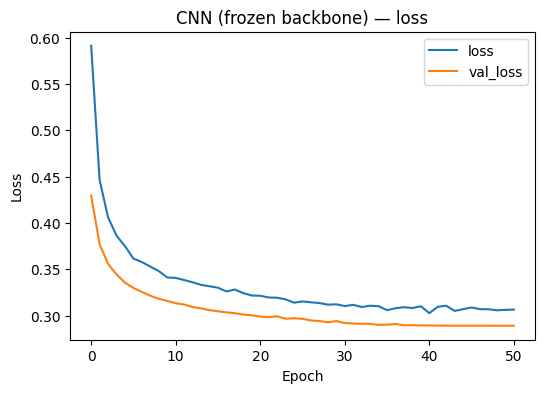

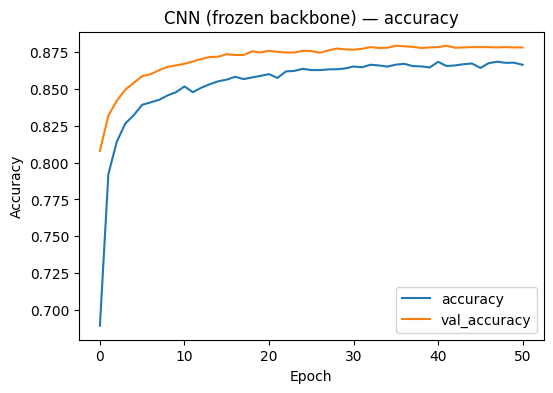

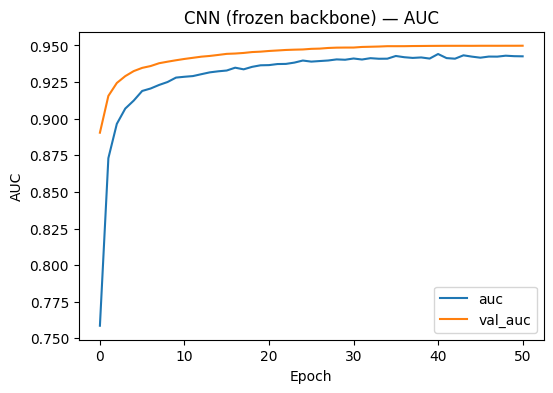

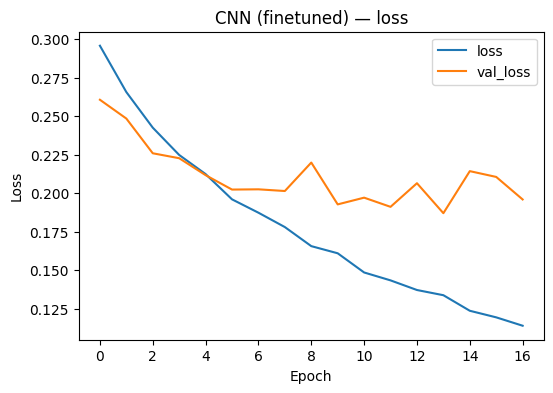

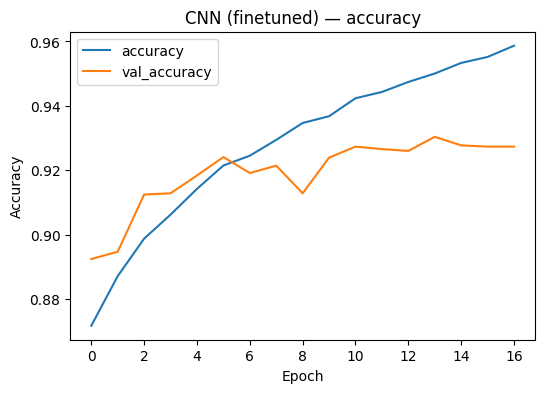

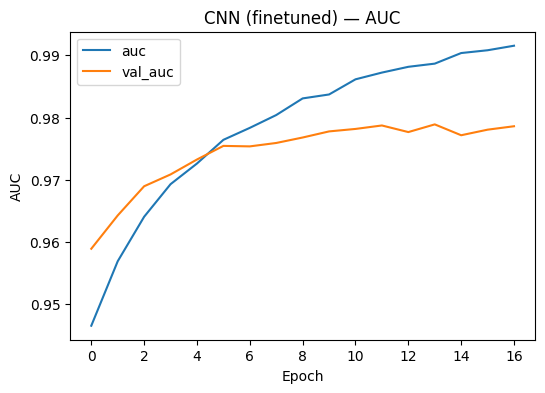

In [20]:
def plot_history(hist, title="Training curves"):
    hist = hist.history
    plt.figure(figsize=(6,4))
    plt.plot(hist.get("loss",[]), label="loss")
    plt.plot(hist.get("val_loss",[]), label="val_loss")
    plt.title(title + " — loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

    if "accuracy" in hist or "acc" in hist:
        acc_key = "accuracy" if "accuracy" in hist else "acc"
        val_acc_key = "val_accuracy" if "val_accuracy" in hist else "val_acc"
        plt.figure(figsize=(6,4))
        plt.plot(hist.get(acc_key,[]), label=acc_key)
        plt.plot(hist.get(val_acc_key,[]), label=val_acc_key)
        plt.title(title + " — accuracy")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.show()

    if "auc" in hist:
        plt.figure(figsize=(6,4))
        plt.plot(hist.get("auc",[]), label="auc")
        plt.plot(hist.get("val_auc",[]), label="val_auc")
        plt.title(title + " — AUC")
        plt.xlabel("Epoch"); plt.ylabel("AUC"); plt.legend(); plt.show()

# Plot for CNN (head + finetune)
plot_history(history_cnn, "CNN (frozen backbone)")
plot_history(history_cnn_ft, "CNN (finetuned)")


# create directory for plots in save_dir
os.makedirs(os.path.join(save_dir, "plots"), exist_ok=True)

# after creating all plots, save them to save_dir
for i in plt.get_fignums():
    fig = plt.figure(i)
    fig.savefig(os.path.join(save_dir, f"plots/training_curve_{i}_{WANDB_ID}.png"))


## 4.1) Prepare final re-fit

In [21]:
print('preparing final refit')

# Train* DataSet (val + train)
#train_star = train_ds.concatenate(val_ds).shuffle(
#    buffer_size=2048, seed=SEED, reshuffle_each_iteration=True
#)
	
train_star = train_ds.concatenate(val_ds)

# update W&B for refit
final_callbacks = [
    WandbMetricsLogger(log_freq="epoch"),
    WandbModelCheckpoint(
        filepath=os.path.join(save_dir, "final_refit.weights.h5"),
        monitor="auc",    # ingen val-data, så brug trænings-AUC
        mode="max",
        save_weights_only=True,
        save_best_only=True,
        save_freq="epoch",
    ),
]

wandb.log({"phase": "final_refit"})

final_model = finetune_model

preparing final refit


## 4.2) Final re-fit on train* (train+val)

In [22]:
print('[FINAL REFIT]')

# Reuse best model weights and ReFit on train*
history_final = final_model.fit(
	train_star,
	epochs=best_ft_epoch,
	verbose=1,
	callbacks=final_callbacks
)

[FINAL REFIT]
Epoch 1/14


2025-11-03 08:48:28.423852: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 579806208 exceeds 10% of free system memory.


410/410 ━━━━━━━━━━━━━━━━━━━━ 70s 170ms/step - accuracy: 0.9462 - auc: 0.9877 - loss: 0.1397
Epoch 2/14
328/410 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - accuracy: 0.9559 - auc: 0.9909 - loss: 0.1193

2025-11-03 08:50:28.959985: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


410/410 ━━━━━━━━━━━━━━━━━━━━ 66s 161ms/step - accuracy: 0.9516 - auc: 0.9897 - loss: 0.1272
Epoch 3/14
328/410 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 0.9544 - auc: 0.9918 - loss: 0.1144

2025-11-03 08:51:36.741933: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


410/410 ━━━━━━━━━━━━━━━━━━━━ 69s 169ms/step - accuracy: 0.9552 - auc: 0.9915 - loss: 0.1156
Epoch 4/14
410/410 ━━━━━━━━━━━━━━━━━━━━ 72s 176ms/step - accuracy: 0.9615 - auc: 0.9928 - loss: 0.1039
Epoch 5/14
328/410 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - accuracy: 0.9562 - auc: 0.9914 - loss: 0.1149

2025-11-03 08:54:00.636021: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


410/410 ━━━━━━━━━━━━━━━━━━━━ 71s 172ms/step - accuracy: 0.9615 - auc: 0.9931 - loss: 0.1024
Epoch 6/14
410/410 ━━━━━━━━━━━━━━━━━━━━ 70s 172ms/step - accuracy: 0.9647 - auc: 0.9941 - loss: 0.0945
Epoch 7/14
410/410 ━━━━━━━━━━━━━━━━━━━━ 71s 174ms/step - accuracy: 0.9690 - auc: 0.9949 - loss: 0.0857
Epoch 8/14
328/410 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step - accuracy: 0.9673 - auc: 0.9952 - loss: 0.0849

2025-11-03 08:57:33.512399: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


410/410 ━━━━━━━━━━━━━━━━━━━━ 72s 174ms/step - accuracy: 0.9706 - auc: 0.9957 - loss: 0.0800
Epoch 9/14
410/410 ━━━━━━━━━━━━━━━━━━━━ 71s 173ms/step - accuracy: 0.9704 - auc: 0.9957 - loss: 0.0792
Epoch 10/14
410/410 ━━━━━━━━━━━━━━━━━━━━ 72s 175ms/step - accuracy: 0.9721 - auc: 0.9962 - loss: 0.0743
Epoch 11/14
410/410 ━━━━━━━━━━━━━━━━━━━━ 72s 175ms/step - accuracy: 0.9744 - auc: 0.9968 - loss: 0.0678
Epoch 12/14
328/410 ━━━━━━━━━━━━━━━━━━━━ 13s 166ms/step - accuracy: 0.9732 - auc: 0.9960 - loss: 0.0771

2025-11-03 09:02:19.121442: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


410/410 ━━━━━━━━━━━━━━━━━━━━ 70s 172ms/step - accuracy: 0.9766 - auc: 0.9972 - loss: 0.0648
Epoch 13/14
410/410 ━━━━━━━━━━━━━━━━━━━━ 72s 176ms/step - accuracy: 0.9765 - auc: 0.9971 - loss: 0.0637
Epoch 14/14
410/410 ━━━━━━━━━━━━━━━━━━━━ 73s 178ms/step - accuracy: 0.9776 - auc: 0.9974 - loss: 0.0609


In [23]:
final_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocess (Lambda)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ backbone (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,431,941 (158.05 MB)

 Trainable params: 8,921,089 (34.03 MB)

 Non-trainable params: 14,668,672 (55.96 MB)

 Optimizer params: 17,842,180 (68.06 MB)

In [24]:
# Save final refitted model
final_model.save(os.path.join(save_dir, f"model_final_refit_{WANDB_ID}.keras"))

## 4.3) Log to W&B

In [25]:
# W&B Artifact
artifact = wandb.Artifact(
    name=f"{MODEL_NAME}_seed{SEED}_{WANDB_ID}_final_refit",
    type="model",
    metadata={
        "model_name": MODEL_NAME,
        "img_size": IMG_SIZE,
        "seed": SEED,
        "finetune_lr": LR * 0.1,
        "refit_epochs_total": int(best_ft_epoch),
        "phase": "final_refit",
        "source_run_id": WANDB_ID,
    },
)

artifact.add_file(os.path.join(save_dir, f"model_final_refit_{WANDB_ID}.keras"))

artifact.add_file(save_dir + "/final_refit.weights.h5")
wandb.log_artifact(artifact)

# W&B Metrics 📊 for final refit
final_metrics = {
    "final_refit_best_epoch": np.argmax(history_final.history["auc"]) + 1,
    "final_refit_last_epoch": len(history_final.history["loss"]),
    "final_refit_best_auc": float(np.max(history_final.history["auc"])),
    "final_refit_last_auc": float(history_final.history["auc"][-1]),
    "final_refit_best_loss": float(np.min(history_final.history["loss"])),
    "final_refit_last_loss": float(history_final.history["loss"][-1]),
}

wandb.log(final_metrics)

print(f"[FINAL REFIT] Done ✅")
print(f"[FINAL REFIT] ✅ Model saved: {save_dir}")
print(f"[FINAL REFIT] 🪄 W&B artifact: {artifact.name}")

#finish wandb
wandb.finish()

[FINAL REFIT] Done ✅
[FINAL REFIT] ✅ Model saved: ModelWeights/resnet50_seed42_xxvh4y17
[FINAL REFIT] 🪄 W&B artifact: resnet50_seed42_xxvh4y17_final_refit


cnn_val_acc_ft,▁
cnn_val_acc_tl,▁
cnn_val_auc_ft,▁
cnn_val_auc_tl,▁
cnn_val_loss_ft,▁
cnn_val_loss_tl,▁
epoch/accuracy,▁▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▆▆▇▇▇▇▇▇██
epoch/auc,▁▂▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▇▇▇▇▇▇██▇██████
epoch/epoch,▁▁▁▂▂▂▃▃▃▃▄▅▅▅▅▆▆▆▆▆▇▇█▁▁▂▂▂▃▃▃▁▁▁▂▂▂▂▃▃
epoch/learning_rate,█████████████████▃▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
+10,...


### 5) Export CSV with probabilities (on test)

In [26]:
# Generate submission csv using test_ds
y_test_hat = final_model.predict(test_ds, verbose=1)
ytest_hat = pd.DataFrame({
    'Id': list(range(len(y_test_hat))),
    'Predicted': y_test_hat.reshape(-1,),
})

# create directory for csv export inside save_dir
os.makedirs(os.path.join(save_dir, "csv"), exist_ok=True)
ytest_hat.to_csv(f'{save_dir}/csv/ytest_hat_{WANDB_ID}.csv', index=False)

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step

2025-11-03 09:09:24.943735: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{} for conv (f32[38,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[38,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-11-03 09:09:25.521833: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{} for conv (f32[38,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[38,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$

26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 347ms/step


### 6) Find optimal accuracy threshold based on validation

In [27]:
# === A) Find optimal threshold på val_ds (max accuracy) ===
import numpy as np
from sklearn.metrics import accuracy_score

print("[THR] Finder optimal threshold på val_ds (baseret på accuracy)")

# 1) Hent y_true og p_hat fra val_ds
y_val_true = []
for _, y in val_ds:
    y_val_true.append(y.numpy())
y_val_true = np.concatenate(y_val_true).astype(int)

# Keras .predict giver sandsynligheder (antager sigmoid i sidste lag)
y_val_prob = final_model.predict(val_ds, verbose=0).reshape(-1)

# 2) Grid-scan thresholds i [0.0, 1.0]
thr_grid = np.linspace(0.0, 1.0, 1001)  # opløsning 0.001
accs = []

for thr in thr_grid:
    y_val_pred = (y_val_prob >= thr).astype(int)
    accs.append(accuracy_score(y_val_true, y_val_pred))

accs = np.array(accs)
best_idx = int(np.argmax(accs))
best_thr = float(thr_grid[best_idx])
best_acc = float(accs[best_idx])

print(f"[THR] Bedste threshold = {best_thr:.3f} med val-accuracy = {best_acc:.4f}")

# (valgfrit) log til W&B
try:
    wandb.log({"threshold/best": best_thr, "threshold/val_accuracy": best_acc})
except Exception as e:
    print("[THR] W&B log skipped:", e)


[THR] Finder optimal threshold på val_ds (baseret på accuracy)


2025-11-03 09:09:33.022463: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[THR] Bedste threshold = 0.564 med val-accuracy = 0.9985
[THR] W&B log skipped: You must call wandb.init() before wandb.log()


In [ ]:
# calculate best threshold plot based on Cross validation k-fold 10, with 0.8 train and 0.2 val splits

# setup new datasplit from original train data
X_tr_final, X_val_final, y_tr_final, y_val_final = train_test_split(
	Xtrain, ytrain, test_size=0.2, random_state=42, stratify=ytrain
)

# use cross validation to find best threshold with 10 folds
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# for each fold find best threshold
best_thresholds = []
for train_index, val_index in kf.split(X_tr_final):
	X_tr_fold, X_val_fold = X_tr_final[train_index], X_tr_final[val_index]
	y_tr_fold, y_val_fold = y_tr_final[train_index], y_tr_final[val_index]

	# create datasets
	train_ds_fold = make_train_ds(X_tr_fold, y_tr_fold)
	val_ds_fold = make_eval_ds(X_val_fold, y_val_fold)

	# predict on val_ds_fold
	y_val_prob_fold = final_model.predict(val_ds_fold, verbose=0).reshape(-1)

	# get true labels
	y_val_true_fold = []
	for _, y in val_ds_fold:
		y_val_true_fold.append(y.numpy())
	y_val_true_fold = np.concatenate(y_val_true_fold).astype(int)

	# grid scan thresholds
	thr_grid = np.linspace(0.0, 1.0, 1001)
	accs = []

	for thr in thr_grid:
		y_val_pred_fold = (y_val_prob_fold >= thr).astype(int)
		accs.append(accuracy_score(y_val_true_fold, y_val_pred_fold))

	accs = np.array(accs)
	best_idx = int(np.argmax(accs))
	best_thr = float(thr_grid[best_idx])
	best_thresholds.append(best_thr)

mean_best_thr = np.mean(best_thresholds)
std_best_thr = np.std(best_thresholds)

print(f"[THR CV] Mean best threshold from CV = {mean_best_thr:.3f} ± {std_best_thr:.3f}")

In [28]:
# === B) Generér 0/1 Kaggle-CSV fra test_ds ved brug af best_thr ===
import os
import pandas as pd

assert "best_thr" in globals(), "Kør først threshold-cellen (A), så 'best_thr' findes."

# 1) Hent P(y=1) på test
y_test_prob = final_model.predict(test_ds, verbose=1).reshape(-1)

# 2) Threshold til 0/1
y_test_label = (y_test_prob >= best_thr).astype(int)

# 3) Gem CSV
os.makedirs(os.path.join(save_dir, "csv"), exist_ok=True)
csv_path = os.path.join(save_dir, "csv", f"submission_threshold_{best_thr:.3f}_{WANDB_ID}.csv")
pd.DataFrame({"Id": np.arange(len(y_test_label)), "Predicted": y_test_label}).to_csv(csv_path, index=False)

print(f"[SUBMIT] Skrev 0/1-label CSV til:\n{csv_path}")

# (valgfrit) log filen som W&B-artifact
try:
    art = wandb.Artifact(
        name=f"{MODEL_NAME}_seed{SEED}_{WANDB_ID}_submission_thr",
        type="submission",
        metadata={"threshold": best_thr, "source_run_id": WANDB_ID}
    )
    art.add_file(csv_path)
    wandb.log_artifact(art)
except Exception as e:
    print("[SUBMIT] W&B artifact skip:", e)


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step
[SUBMIT] Skrev 0/1-label CSV til:
ModelWeights/resnet50_seed42_xxvh4y17/csv/submission_threshold_0.564_xxvh4y17.csv
[SUBMIT] W&B artifact skip: You must call wandb.init() before wandb.log_artifact()
